# Assignment 1

In [ ]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

In [1]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "Your path to assignment folder" #@param {type:"string"}
!ln -Ts "$folder" /content/assignment 2> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

/var/folders/sk/8z_2wkxn7hx2ytzbzxsgwdjm0000gn/T/ipykernel_91608/1837915109.py:21: UserWarning: CUDA is not available.
  warnings.warn('CUDA is not available.')


### Running on GPU
For this assignment, it will be necessary to run your experiments on GPU. To make sure the notebook is running on GPU, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`


In [1]:
%matplotlib inline
import warnings

from dataclasses import dataclass
import torch
from torch import optim
from torchvision.datasets import CIFAR10
from torchvision import transforms
from utils import seed_experiment, to_device, cross_entropy_loss, compute_accuracy
from config import get_config_parser
import json
from mlp import MLP
from resnet18 import ResNet18
from mlpmixer import MLPMixer
from tqdm import tqdm
from torch.utils.data import DataLoader
import time
import os

# Local Test
Before run the experiment, here are some local test cases you can run for sanity check

In [2]:
import unittest
import test
suite = unittest.TestLoader().loadTestsFromModule(test)
unittest.TextTestRunner(verbosity=2).run(suite)

test_linear_attributes (test.TestLinear) ... ok
test_linear_forward (test.TestLinear) ... ok
test_activation (test.TestMLP) ... ok
test_forward (test.TestMLP) ... ok
test_mlp (test.TestMLP) ... ok
test_mixer_block (test.TestMLPMixer) ... ok
test_mlpmixer (test.TestMLPMixer) ... ok
test_patch_emb (test.TestMLPMixer) ... ok
test_basic_block (test.TestResNet) ... ok
test_basic_block2 (test.TestResNet) ... ok
test_resnet (test.TestResNet) ... ok
test_ce_loss (test.TestUtils) ... ok

----------------------------------------------------------------------
Ran 12 tests in 1.068s

OK


<unittest.runner.TextTestResult run=12 errors=0 failures=0>

## Experiments

Below we define a few default arguments to get you started with your experiments. You are encouraged to modify the function `main_entry()`, as well as these arguments, to fit your needs (e.g. changing hyperparameters, the optimizer, adding regularizations).

In [3]:
@dataclass
class Arguments:
  # Data
  batch_size: int = 128
  # Model
  model: str = 'mlp'  # [mlp, resnet18, mlpmixer]
  model_config: str = "./model_configs/mlp.json" # path to model config json file

  # Optimization
  optimizer: str = 'adam'  # [sgd, momentum, adam, adamw]
  epochs: int = 15
  lr: float = 1e-3
  momentum: float = 0.9
  weight_decay: float = 5e-4

  # Experiment
  logdir: str = 'experiments'
  filename: str = None
  seed: int = 42

  # Miscellaneous
  # device: str = 'cpu'
  device: str = 'mps'
  visualize : bool = False
  print_every: int = 80

In [4]:
# Main code entry. Train the model and save the logs
from main import train, evaluate
import datetime

def main_entry(args):
    # Check for the device
    if args.device == "cuda":
        if not torch.cuda.is_available():
            warnings.warn("CUDA is not available. Falling back to 'mps' if available, otherwise 'cpu'.")
            args.device = "mps" if torch.backends.mps.is_available() else "cpu"
    elif args.device == "mps":
        if not torch.backends.mps.is_available():
            warnings.warn("MPS is not available on this device. Falling back to 'cpu'.")
            args.device = "cpu"

    if args.device == "cpu":
        warnings.warn("Running on CPU. You may run out of memory; consider using a smaller batch size.")
        
    print(f'\n------ Using device {args.device} ------\n')
    

    # Seed the experiment, for repeatability
    seed_experiment(args.seed)

    test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
    # For training, we add some augmentation. Networks are too powerful and would overfit.
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                        ])
    # Loading the training dataset. We need to split it into a training and validation part
    # We need to do a little trick because the validation set should not use the augmentation.
    train_dataset = CIFAR10(root='./data', train=True, transform=train_transform, download=True)
    val_dataset = CIFAR10(root='./data', train=True, transform=test_transform, download=True)
    train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
    _, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

    # Loading the test set
    test_set = CIFAR10(root='./data', train=False, transform=test_transform, download=True)
    
    # Load model
    print(f'Build model {args.model.upper()}...')
    if args.model_config is not None:
        print(f'Loading model config from {args.model_config}')
        with open(args.model_config) as f:
            model_config = json.load(f)
    else:
        raise ValueError('Please provide a model config json')
    print(f'########## {args.model.upper()} CONFIG ################')
    for key, val in model_config.items():
        print(f'{key}:\t{val}')
    print('############################################')
    model_cls = {'mlp': MLP, 'resnet18': ResNet18, 'mlpmixer': MLPMixer}[args.model]
    model = model_cls(**model_config)
    model.to(args.device)
    
    # Optimizer
    if args.optimizer == "adamw":
        optimizer = optim.AdamW(
            model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
    elif args.optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
    elif args.optimizer == "sgd":
        optimizer = optim.SGD(
            model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
    elif args.optimizer == "momentum":
        optimizer = optim.SGD(
            model.parameters(),
            lr=args.lr,
            momentum=args.momentum,
            weight_decay=args.weight_decay,
        )
    
    print(
        f"Initialized {args.model.upper()} model with {sum(p.numel() for p in model.parameters())} "
        f"total parameters, of which {sum(p.numel() for p in model.parameters() if p.requires_grad)} are learnable."
    )

    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    train_times, valid_times = [], []
    
    # We define a set of data loaders that we can use for various purposes later.
    train_dataloader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
    valid_dataloader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, drop_last=False, num_workers=4)
    test_dataloader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, drop_last=False, num_workers=4)
    for epoch in range(args.epochs):
        tqdm.write(f"====== Epoch {epoch} ======>")
        loss, acc, wall_time = train(epoch, model, train_dataloader, optimizer, args)
        train_losses.append(loss)
        train_accs.append(acc)
        train_times.append(wall_time)

        loss, acc, wall_time = evaluate(epoch, model, valid_dataloader, args)
        valid_losses.append(loss)
        valid_accs.append(acc)
        valid_times.append(wall_time)

    test_loss, test_acc, test_time = evaluate(
        epoch, model, test_dataloader, args, mode="test"
    )
    print(f"===== Best validation Accuracy: {max(valid_accs):.3f} =====>")

    # Save results
    if args.logdir is not None:
        print(f'Writing training logs to {args.logdir}...')
        os.makedirs(args.logdir, exist_ok=True)

        # Set filename based on argument or default
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'{args.filename}_results.json' if args.filename else f'results_{args.model}_{timestamp}.json'

        with open(os.path.join(args.logdir, filename), 'w') as f:
            json.dump({
                "train_losses": train_losses,
                "valid_losses": valid_losses,
                "train_accs": train_accs,
                "valid_accs": valid_accs,
                "test_loss": test_loss,
                "test_acc": test_acc
            }, f, indent=4)

        print(f'Saved results to {filename}')
        
        # Visualize
        if args.visualize and args.model in ['resnet18', 'mlpmixer']:
            model.visualize(args.logdir)


# MLP with different activation functions:

Plot saved to plots/mlp_results.png


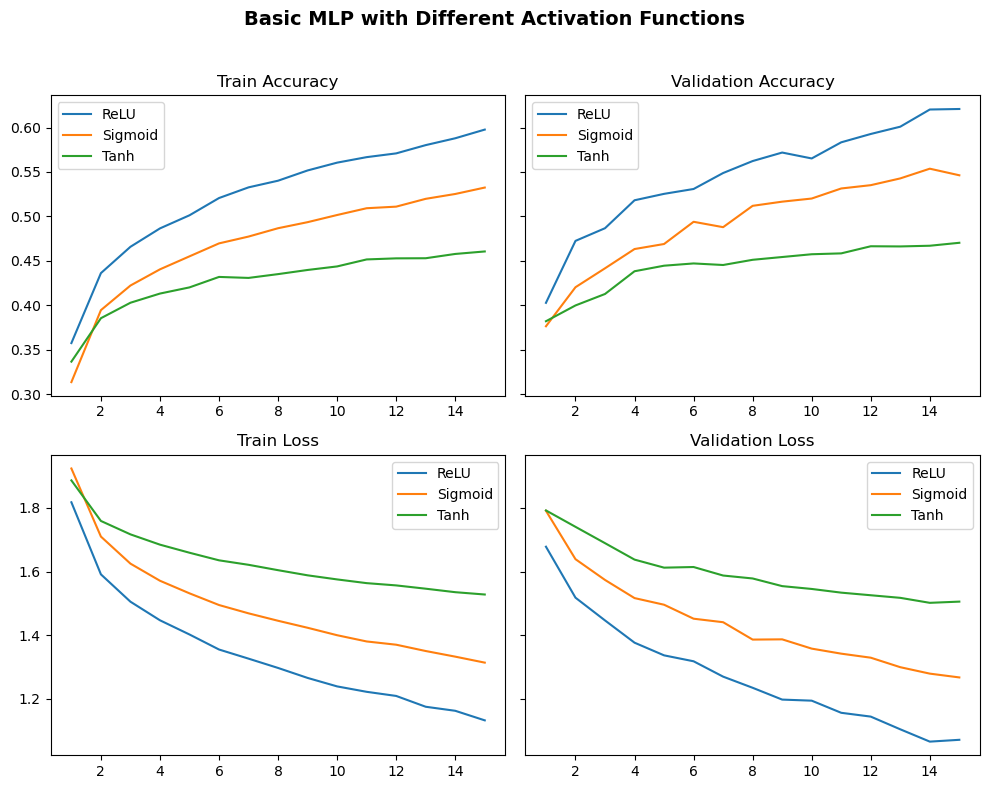

In [5]:
from utils import plot_results

filenames = ['mlp_relu_results.json', 'mlp_sigmoid_results.json', 'mlp_tanh_results.json']
plotnames = ['ReLU', 'Sigmoid', 'Tanh']
# plot_dir = 'plots'
logdir = 'experiments'
save_path = 'plots/mlp_results'

plot_results(logdir, filenames, plotnames=plotnames, save_path=save_path, title='Basic MLP with Different Activation Functions')

# Resnet18 Learning Rates

Plot saved to plots/resnet_lr_results.png


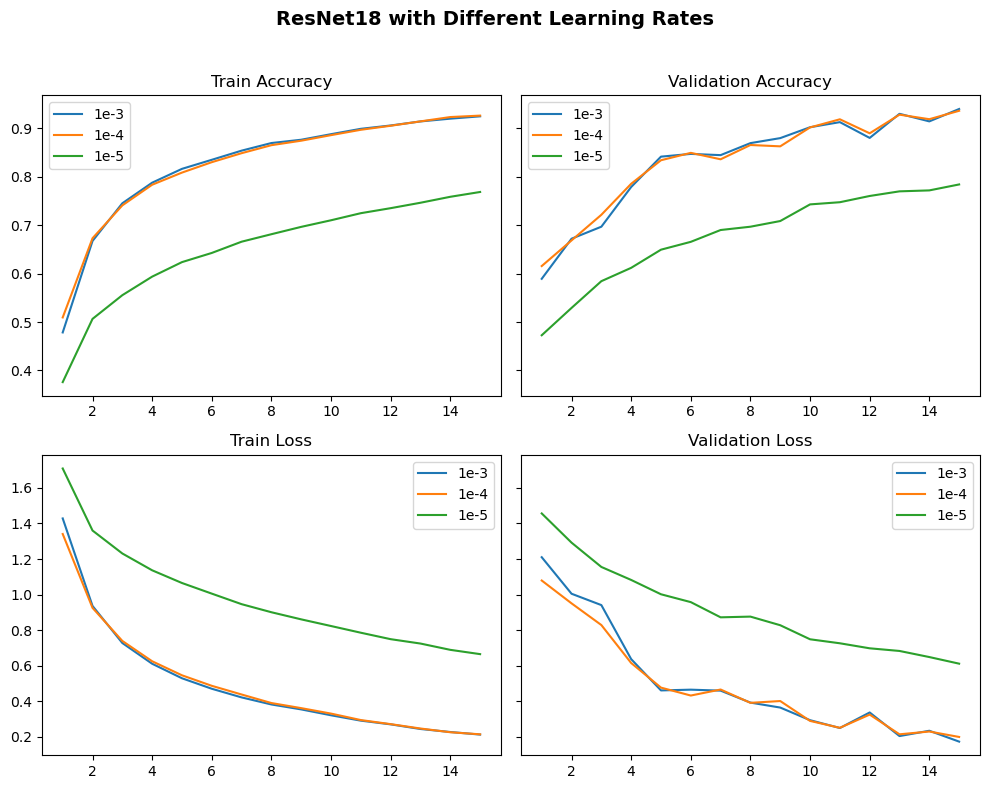

In [6]:
filenames = ['resnet18_lr_0_001_results.json', 'resnet18_lr_0_0001_results.json', 'resnet18_lr_0_00001_results.json']
plotnames = ['1e-3', '1e-4', '1e-5']
# plot_dir = 'plots'
logdir = 'experiments'
save_path = 'plots/resnet_lr_results'

plot_results(logdir, filenames, plotnames=plotnames, save_path=save_path, title='ResNet18 with Different Learning Rates')

# MLPMixer Patch Sizes

In [14]:
import json
import subprocess

config_path = "./model_configs/mlpmixer.json"

# Define patch sizes to test
patch_sizes = [2, 4, 8, 16]

# Loop through different patch sizes
for patch_size in patch_sizes:
    
    print('-'*70, '\n', f'Running with patch size = {patch_size}', '\n', '-'*70)
    
    with open(config_path, "r") as f:
        config = json.load(f)
    
    # Modify the patch_size
    config["patch_size"] = patch_size
    
    # Save the updated config
    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)
        
    filename = f'mlpmixer_patch_{patch_size}'
    
    # Run the MLP-Mixer model training with updated config
    subprocess.run(["python", "main.py", "--model", "mlpmixer", 
                    "--model_config", config_path,
                    '--filename', filename], check=True)
    
    print(f"Finished training with patch_size={patch_size}\n\n\n")


---------------------------------------------------------------------- 
 Running with patch size = 2 
 ----------------------------------------------------------------------
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 2376458 total parameters, of which 2376458 are learnable.
 Using adam optimizer with learning rate 0.001.
====== Epoch 0 ======>


Epoch 0: 100%|██████████| 351/351 [02:10<00:00,  2.68batch/s, acc=0.438, loss=1.41]


== [TRAIN] Epoch: 0, Accuracy: 0.417, Training Time: 130.911 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.40212
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.500 ===>
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:51<00:00,  3.39batch/s, acc=0.594, loss=1.22] 

== [TRAIN] Epoch: 1, Accuracy: 0.544, Training Time: 131.773 ==


Epoch 1: 100%|██████████| 351/351 [02:11<00:00,  2.66batch/s, acc=0.594, loss=1.22]


[VAL] Epoch: 1, Iter: 0, Loss: 1.26823
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.588 ===>
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [02:12<00:00,  2.66batch/s, acc=0.617, loss=1.13] 


== [TRAIN] Epoch: 2, Accuracy: 0.586, Training Time: 132.078 ==
[VAL] Epoch: 2, Iter: 0, Loss: 1.18696
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.601 ===>
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [02:11<00:00,  2.67batch/s, acc=0.617, loss=1.16] 


== [TRAIN] Epoch: 3, Accuracy: 0.619, Training Time: 131.575 ==
[VAL] Epoch: 3, Iter: 0, Loss: 1.09918
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.650 ===>
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [02:14<00:00,  2.61batch/s, acc=0.711, loss=0.872]


== [TRAIN] Epoch: 4, Accuracy: 0.644, Training Time: 134.450 ==
[VAL] Epoch: 4, Iter: 0, Loss: 1.02694
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.674 ===>
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [02:13<00:00,  2.64batch/s, acc=0.695, loss=0.888]


== [TRAIN] Epoch: 5, Accuracy: 0.668, Training Time: 133.088 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.97209
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.680 ===>
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [02:13<00:00,  2.63batch/s, acc=0.75, loss=0.861] 


== [TRAIN] Epoch: 6, Accuracy: 0.691, Training Time: 133.293 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.92877
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.678 ===>
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [02:10<00:00,  2.69batch/s, acc=0.688, loss=0.884]


== [TRAIN] Epoch: 7, Accuracy: 0.712, Training Time: 130.486 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.86078
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.726 ===>
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [02:09<00:00,  2.72batch/s, acc=0.617, loss=1.03] 


== [TRAIN] Epoch: 8, Accuracy: 0.724, Training Time: 129.213 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.77493
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.754 ===>
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [02:09<00:00,  2.71batch/s, acc=0.789, loss=0.649]


== [TRAIN] Epoch: 9, Accuracy: 0.743, Training Time: 129.660 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.76879
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.775 ===>
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [02:09<00:00,  2.71batch/s, acc=0.828, loss=0.576]


== [TRAIN] Epoch: 10, Accuracy: 0.758, Training Time: 129.354 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.72196
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.777 ===>
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [02:09<00:00,  2.71batch/s, acc=0.75, loss=0.708] 


== [TRAIN] Epoch: 11, Accuracy: 0.777, Training Time: 129.410 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.74669
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.779 ===>
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [02:12<00:00,  2.65batch/s, acc=0.789, loss=0.583]


== [TRAIN] Epoch: 12, Accuracy: 0.789, Training Time: 132.266 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.64724
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.807 ===>
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [02:11<00:00,  2.67batch/s, acc=0.812, loss=0.525]


== [TRAIN] Epoch: 13, Accuracy: 0.806, Training Time: 131.497 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.57731
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.810 ===>
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [02:18<00:00,  2.54batch/s, acc=0.844, loss=0.438]


== [TRAIN] Epoch: 14, Accuracy: 0.819, Training Time: 138.445 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.48590
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.837 ===>
[TEST] Epoch: 14, Iter: 0, Loss: 0.68754
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.729 ===>
===== Best validation Accuracy: 0.837 =====>
Writing training logs to experiments...
Saved results to mlpmixer_patch_2_results.json
Finished training with patch_size=2



---------------------------------------------------------------------- 
 Running with patch size = 4 
 ----------------------------------------------------------------------
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 2188298 total parameters, of which 2188298 are learnable.
 Using adam optimizer with learning rate 0.001.
====== Epoch 0 ======>


Epoch 0: 100%|██████████| 351/351 [01:00<00:00,  5.78batch/s, acc=0.523, loss=1.4] 


== [TRAIN] Epoch: 0, Accuracy: 0.409, Training Time: 60.681 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.44316
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.504 ===>
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:00<00:00,  5.80batch/s, acc=0.539, loss=1.28]


== [TRAIN] Epoch: 1, Accuracy: 0.534, Training Time: 60.555 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.32773
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.569 ===>
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [01:00<00:00,  5.79batch/s, acc=0.516, loss=1.19] 


== [TRAIN] Epoch: 2, Accuracy: 0.584, Training Time: 60.663 ==
[VAL] Epoch: 2, Iter: 0, Loss: 1.19211
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.618 ===>
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [00:56<00:00,  6.18batch/s, acc=0.625, loss=1.06] 


== [TRAIN] Epoch: 3, Accuracy: 0.617, Training Time: 56.826 ==
[VAL] Epoch: 3, Iter: 0, Loss: 1.18691
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.633 ===>
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [00:58<00:00,  6.04batch/s, acc=0.688, loss=0.92] 


== [TRAIN] Epoch: 4, Accuracy: 0.639, Training Time: 58.148 ==
[VAL] Epoch: 4, Iter: 0, Loss: 1.15790
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.663 ===>
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [00:59<00:00,  5.92batch/s, acc=0.672, loss=0.914]


== [TRAIN] Epoch: 5, Accuracy: 0.664, Training Time: 59.277 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.99916
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.692 ===>
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [00:57<00:00,  6.06batch/s, acc=0.672, loss=0.967]


== [TRAIN] Epoch: 6, Accuracy: 0.686, Training Time: 57.915 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.98368
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.700 ===>
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [00:58<00:00,  5.98batch/s, acc=0.719, loss=0.897]


== [TRAIN] Epoch: 7, Accuracy: 0.701, Training Time: 58.693 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.82014
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.725 ===>
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [00:57<00:00,  6.07batch/s, acc=0.727, loss=0.846]


== [TRAIN] Epoch: 8, Accuracy: 0.719, Training Time: 57.838 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.76470
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.728 ===>
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [00:56<00:00,  6.17batch/s, acc=0.719, loss=0.833]


== [TRAIN] Epoch: 9, Accuracy: 0.730, Training Time: 56.900 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.73781
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.747 ===>
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [00:56<00:00,  6.17batch/s, acc=0.727, loss=0.791]


== [TRAIN] Epoch: 10, Accuracy: 0.744, Training Time: 56.873 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.71077
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.767 ===>
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [00:57<00:00,  6.06batch/s, acc=0.68, loss=0.857] 


== [TRAIN] Epoch: 11, Accuracy: 0.755, Training Time: 57.969 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.77943
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.778 ===>
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [00:56<00:00,  6.17batch/s, acc=0.766, loss=0.605]


== [TRAIN] Epoch: 12, Accuracy: 0.770, Training Time: 56.920 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.64186
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.793 ===>
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [00:57<00:00,  6.13batch/s, acc=0.859, loss=0.436]


== [TRAIN] Epoch: 13, Accuracy: 0.778, Training Time: 57.252 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.58669
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.803 ===>
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [00:56<00:00,  6.19batch/s, acc=0.852, loss=0.555]


== [TRAIN] Epoch: 14, Accuracy: 0.795, Training Time: 56.680 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.55967
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.820 ===>
[TEST] Epoch: 14, Iter: 0, Loss: 0.64321
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.726 ===>
===== Best validation Accuracy: 0.820 =====>
Writing training logs to experiments...
Saved results to mlpmixer_patch_4_results.json
Finished training with patch_size=4



---------------------------------------------------------------------- 
 Running with patch size = 8 
 ----------------------------------------------------------------------
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 2175818 total parameters, of which 2175818 are learnable.
 Using adam optimizer with learning rate 0.001.
====== Epoch 0 ======>


Epoch 0: 100%|██████████| 351/351 [00:43<00:00,  8.14batch/s, acc=0.438, loss=1.54]


== [TRAIN] Epoch: 0, Accuracy: 0.360, Training Time: 43.119 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.53698
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.446 ===>
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [00:43<00:00,  8.02batch/s, acc=0.422, loss=1.4] 


== [TRAIN] Epoch: 1, Accuracy: 0.475, Training Time: 43.755 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.52178
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.508 ===>
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [00:43<00:00,  8.11batch/s, acc=0.516, loss=1.35]


== [TRAIN] Epoch: 2, Accuracy: 0.522, Training Time: 43.262 ==
[VAL] Epoch: 2, Iter: 0, Loss: 1.44224
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.549 ===>
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [00:43<00:00,  7.98batch/s, acc=0.648, loss=0.967]


== [TRAIN] Epoch: 3, Accuracy: 0.556, Training Time: 43.965 ==
[VAL] Epoch: 3, Iter: 0, Loss: 1.28201
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.603 ===>
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [00:43<00:00,  8.03batch/s, acc=0.539, loss=1.21] 


== [TRAIN] Epoch: 4, Accuracy: 0.580, Training Time: 43.688 ==
[VAL] Epoch: 4, Iter: 0, Loss: 1.22986
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.613 ===>
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [00:43<00:00,  8.03batch/s, acc=0.672, loss=1.08] 


== [TRAIN] Epoch: 5, Accuracy: 0.601, Training Time: 43.690 ==
[VAL] Epoch: 5, Iter: 0, Loss: 1.22098
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.633 ===>
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [00:44<00:00,  7.88batch/s, acc=0.617, loss=1.13] 


== [TRAIN] Epoch: 6, Accuracy: 0.617, Training Time: 44.566 ==
[VAL] Epoch: 6, Iter: 0, Loss: 1.11264
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.649 ===>
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [00:44<00:00,  7.83batch/s, acc=0.523, loss=1.22] 


== [TRAIN] Epoch: 7, Accuracy: 0.632, Training Time: 44.824 ==
[VAL] Epoch: 7, Iter: 0, Loss: 1.06657
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.663 ===>
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [00:44<00:00,  7.90batch/s, acc=0.672, loss=0.819]


== [TRAIN] Epoch: 8, Accuracy: 0.646, Training Time: 44.428 ==
[VAL] Epoch: 8, Iter: 0, Loss: 1.01642
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.674 ===>
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [00:43<00:00,  8.02batch/s, acc=0.641, loss=0.997]


== [TRAIN] Epoch: 9, Accuracy: 0.659, Training Time: 43.765 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.95241
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.708 ===>
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [00:43<00:00,  8.03batch/s, acc=0.586, loss=1.08] 


== [TRAIN] Epoch: 10, Accuracy: 0.675, Training Time: 43.715 ==
[VAL] Epoch: 10, Iter: 0, Loss: 1.09293
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.696 ===>
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [00:43<00:00,  8.03batch/s, acc=0.617, loss=1]    


== [TRAIN] Epoch: 11, Accuracy: 0.686, Training Time: 43.730 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.81843
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.725 ===>
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [00:43<00:00,  7.99batch/s, acc=0.664, loss=0.983]


== [TRAIN] Epoch: 12, Accuracy: 0.699, Training Time: 43.905 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.85880
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.733 ===>
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [00:43<00:00,  7.99batch/s, acc=0.727, loss=0.739]


== [TRAIN] Epoch: 13, Accuracy: 0.712, Training Time: 43.940 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.83732
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.755 ===>
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [00:43<00:00,  8.03batch/s, acc=0.656, loss=0.863]


== [TRAIN] Epoch: 14, Accuracy: 0.722, Training Time: 43.687 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.78261
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.752 ===>
[TEST] Epoch: 14, Iter: 0, Loss: 0.80317
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.640 ===>
===== Best validation Accuracy: 0.755 =====>
Writing training logs to experiments...
Saved results to mlpmixer_patch_8_results.json
Finished training with patch_size=8



---------------------------------------------------------------------- 
 Running with patch size = 16 
 ----------------------------------------------------------------------
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 2310938 total parameters, of which 2310938 are learnable.
 Using adam optimizer with learning rate 0.001.
====== Epoch 0 ======>


Epoch 0: 100%|██████████| 351/351 [00:37<00:00,  9.25batch/s, acc=0.32, loss=1.83] 


== [TRAIN] Epoch: 0, Accuracy: 0.297, Training Time: 37.952 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.90371
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.352 ===>
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [00:39<00:00,  8.89batch/s, acc=0.383, loss=1.91]


== [TRAIN] Epoch: 1, Accuracy: 0.374, Training Time: 39.494 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.72012
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.406 ===>
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [00:38<00:00,  9.09batch/s, acc=0.367, loss=1.75]


== [TRAIN] Epoch: 2, Accuracy: 0.425, Training Time: 38.626 ==
[VAL] Epoch: 2, Iter: 0, Loss: 1.53058
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.446 ===>
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [00:38<00:00,  9.15batch/s, acc=0.422, loss=1.73]


== [TRAIN] Epoch: 3, Accuracy: 0.461, Training Time: 38.349 ==
[VAL] Epoch: 3, Iter: 0, Loss: 1.50676
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.479 ===>
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [00:38<00:00,  9.16batch/s, acc=0.445, loss=1.5] 


== [TRAIN] Epoch: 4, Accuracy: 0.486, Training Time: 38.329 ==
[VAL] Epoch: 4, Iter: 0, Loss: 1.51425
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.503 ===>
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [00:39<00:00,  8.79batch/s, acc=0.578, loss=1.24]


== [TRAIN] Epoch: 5, Accuracy: 0.504, Training Time: 39.918 ==
[VAL] Epoch: 5, Iter: 0, Loss: 1.34331
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.524 ===>
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [00:38<00:00,  9.05batch/s, acc=0.523, loss=1.29]


== [TRAIN] Epoch: 6, Accuracy: 0.520, Training Time: 38.791 ==
[VAL] Epoch: 6, Iter: 0, Loss: 1.36650
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.538 ===>
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [00:39<00:00,  8.81batch/s, acc=0.523, loss=1.33] 


== [TRAIN] Epoch: 7, Accuracy: 0.537, Training Time: 39.852 ==
[VAL] Epoch: 7, Iter: 0, Loss: 1.26704
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.574 ===>
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [00:38<00:00,  9.05batch/s, acc=0.555, loss=1.32]


== [TRAIN] Epoch: 8, Accuracy: 0.548, Training Time: 38.788 ==
[VAL] Epoch: 8, Iter: 0, Loss: 1.25136
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.576 ===>
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [00:38<00:00,  9.09batch/s, acc=0.602, loss=1.1] 


== [TRAIN] Epoch: 9, Accuracy: 0.562, Training Time: 38.630 ==
[VAL] Epoch: 9, Iter: 0, Loss: 1.27172
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.586 ===>
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [00:39<00:00,  8.91batch/s, acc=0.602, loss=1.09] 


== [TRAIN] Epoch: 10, Accuracy: 0.572, Training Time: 39.391 ==
[VAL] Epoch: 10, Iter: 0, Loss: 1.27555
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.598 ===>
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [00:39<00:00,  8.93batch/s, acc=0.594, loss=1.11] 


== [TRAIN] Epoch: 11, Accuracy: 0.585, Training Time: 39.287 ==
[VAL] Epoch: 11, Iter: 0, Loss: 1.21433
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.604 ===>
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [00:38<00:00,  9.15batch/s, acc=0.555, loss=1.23] 


== [TRAIN] Epoch: 12, Accuracy: 0.598, Training Time: 38.354 ==
[VAL] Epoch: 12, Iter: 0, Loss: 1.12042
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.622 ===>
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [00:39<00:00,  8.94batch/s, acc=0.555, loss=1.24] 


== [TRAIN] Epoch: 13, Accuracy: 0.609, Training Time: 39.275 ==
[VAL] Epoch: 13, Iter: 0, Loss: 1.01265
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.638 ===>
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [00:38<00:00,  9.01batch/s, acc=0.578, loss=1.17] 


== [TRAIN] Epoch: 14, Accuracy: 0.620, Training Time: 38.963 ==
[VAL] Epoch: 14, Iter: 0, Loss: 1.00052
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.648 ===>
[TEST] Epoch: 14, Iter: 0, Loss: 1.12534
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.562 ===>
===== Best validation Accuracy: 0.648 =====>
Writing training logs to experiments...
Saved results to mlpmixer_patch_16_results.json
Finished training with patch_size=16





Plot saved to plots/mlpmixer_patch_results.png


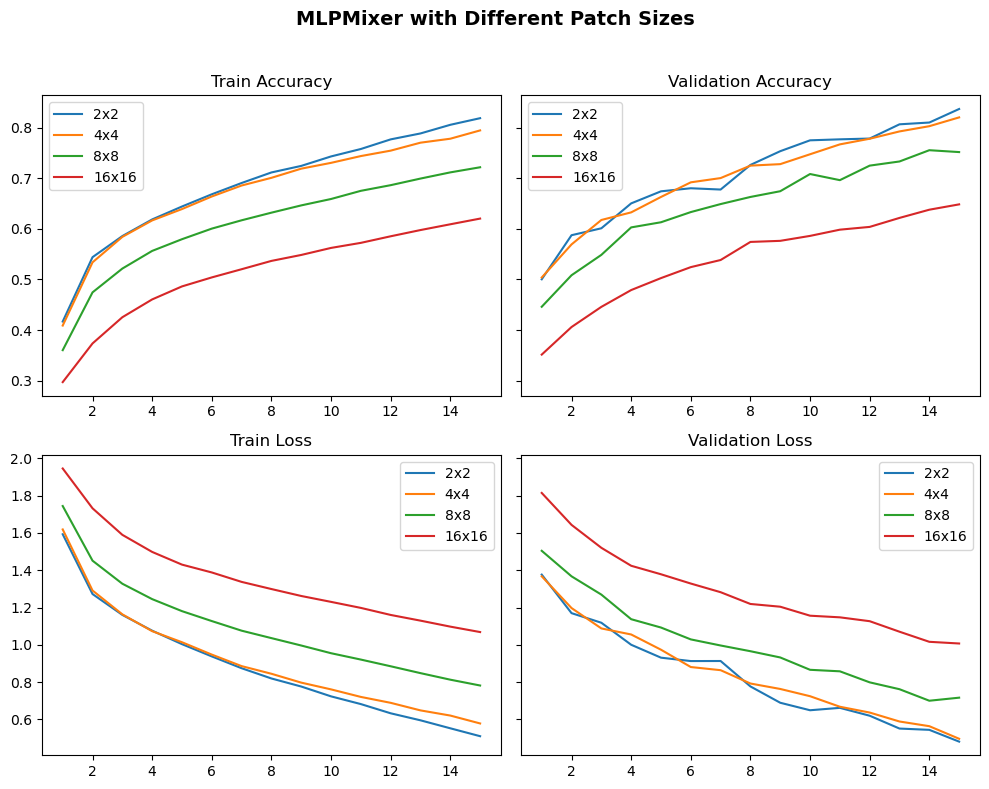

In [15]:
filenames = ['mlpmixer_patch_2_results.json', 'mlpmixer_patch_4_results.json', 'mlpmixer_patch_8_results.json', 'mlpmixer_patch_16_results.json']
plotnames = ['2x2', '4x4', '8x8', '16x16']
# plot_dir = 'plots'
logdir = 'experiments'
save_path = 'plots/mlpmixer_patch_results'

plot_results(logdir, filenames, plotnames=plotnames, save_path=save_path, title='MLPMixer with Different Patch Sizes')

# MLPMixer Embedding Dimensions

In [16]:
config_path = "./model_configs/mlpmixer.json"

# Define patch sizes to test
emb_dims = [128, 512, 1024]

# Loop through different patch sizes
for emb_dim in emb_dims:
    
    print('-'*70, '\n', f'Running with embedding dimension = {emb_dim}', '\n', '-'*70, '\n')
    
    with open(config_path, "r") as f:
        config = json.load(f)
    
    config["patch_size"] = 4
    
    config["embed_dim"] = emb_dim
    
    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)
        
    filename = f'mlpmixer_patch_4_emb_{emb_dim}'
    
    # Run the MLP-Mixer model training with updated config
    subprocess.run(["python", "main.py", "--model", "mlpmixer", 
                    "--model_config", config_path,
                    '--filename', filename], check=True)
    
    print(f"Finished training with embedding dimension = {emb_dim}\n\n\n")

---------------------------------------------------------------------- 
 Running with embedding dimension = 128 
 ---------------------------------------------------------------------- 

Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 569994 total parameters, of which 569994 are learnable.
 Using adam optimizer with learning rate 0.001.
====== Epoch 0 ======>


Epoch 0: 100%|██████████| 351/351 [00:47<00:00,  7.40batch/s, acc=0.547, loss=1.25]


== [TRAIN] Epoch: 0, Accuracy: 0.410, Training Time: 47.420 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.39934
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.508 ===>
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [00:45<00:00,  7.65batch/s, acc=0.633, loss=1.18]


== [TRAIN] Epoch: 1, Accuracy: 0.532, Training Time: 45.884 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.29841
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.565 ===>
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [00:48<00:00,  7.28batch/s, acc=0.641, loss=1.04] 


== [TRAIN] Epoch: 2, Accuracy: 0.575, Training Time: 48.235 ==
[VAL] Epoch: 2, Iter: 0, Loss: 1.25275
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.590 ===>
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [00:44<00:00,  7.94batch/s, acc=0.594, loss=1.04] 


== [TRAIN] Epoch: 3, Accuracy: 0.611, Training Time: 44.230 ==
[VAL] Epoch: 3, Iter: 0, Loss: 1.09654
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.646 ===>
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [00:46<00:00,  7.59batch/s, acc=0.719, loss=0.915]


== [TRAIN] Epoch: 4, Accuracy: 0.635, Training Time: 46.230 ==
[VAL] Epoch: 4, Iter: 0, Loss: 1.11530
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.658 ===>
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [00:45<00:00,  7.76batch/s, acc=0.602, loss=0.979]


== [TRAIN] Epoch: 5, Accuracy: 0.656, Training Time: 45.209 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.98667
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.660 ===>
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [00:46<00:00,  7.59batch/s, acc=0.695, loss=0.799]


== [TRAIN] Epoch: 6, Accuracy: 0.672, Training Time: 46.264 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.93482
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.688 ===>
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [00:45<00:00,  7.79batch/s, acc=0.711, loss=0.833]


== [TRAIN] Epoch: 7, Accuracy: 0.689, Training Time: 45.032 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.91553
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.696 ===>
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [00:44<00:00,  7.90batch/s, acc=0.664, loss=0.796]


== [TRAIN] Epoch: 8, Accuracy: 0.700, Training Time: 44.440 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.88568
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.715 ===>
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [00:44<00:00,  7.94batch/s, acc=0.742, loss=0.738]


== [TRAIN] Epoch: 9, Accuracy: 0.709, Training Time: 44.190 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.89160
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.707 ===>
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [00:43<00:00,  8.01batch/s, acc=0.719, loss=0.742]


== [TRAIN] Epoch: 10, Accuracy: 0.723, Training Time: 43.845 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.78107
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.742 ===>
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [16:55<00:00,  2.89s/batch, acc=0.727, loss=0.731]  


== [TRAIN] Epoch: 11, Accuracy: 0.732, Training Time: 1015.999 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.78396
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.742 ===>
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [00:45<00:00,  7.80batch/s, acc=0.805, loss=0.564]


== [TRAIN] Epoch: 12, Accuracy: 0.742, Training Time: 45.027 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.73828
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.764 ===>
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [00:44<00:00,  7.93batch/s, acc=0.711, loss=0.913]


== [TRAIN] Epoch: 13, Accuracy: 0.749, Training Time: 44.269 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.73360
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.757 ===>
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [00:44<00:00,  7.80batch/s, acc=0.758, loss=0.779]


== [TRAIN] Epoch: 14, Accuracy: 0.757, Training Time: 44.999 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.69931
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.771 ===>
[TEST] Epoch: 14, Iter: 0, Loss: 0.71828
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.709 ===>
===== Best validation Accuracy: 0.771 =====>
Writing training logs to experiments...
Saved results to mlpmixer_patch_16_emb_128_results.json
Finished training with embedding dimension = 128



---------------------------------------------------------------------- 
 Running with embedding dimension = 512 
 ---------------------------------------------------------------------- 

Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 8570634 total parameters, of which 8570634 are learnable.
 Using adam optimizer with learning rate 0.001.
====== Epoch 0 ======>


Epoch 0: 100%|██████████| 351/351 [02:10<00:00,  2.69batch/s, acc=0.469, loss=1.45]


== [TRAIN] Epoch: 0, Accuracy: 0.390, Training Time: 130.533 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.50922
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.478 ===>
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [02:12<00:00,  2.65batch/s, acc=0.633, loss=1.09]


== [TRAIN] Epoch: 1, Accuracy: 0.523, Training Time: 132.589 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.39020
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.549 ===>
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [02:12<00:00,  2.65batch/s, acc=0.562, loss=1.17] 


== [TRAIN] Epoch: 2, Accuracy: 0.569, Training Time: 132.323 ==
[VAL] Epoch: 2, Iter: 0, Loss: 1.15513
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.626 ===>
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [02:10<00:00,  2.69batch/s, acc=0.617, loss=1.1]  


== [TRAIN] Epoch: 3, Accuracy: 0.604, Training Time: 130.604 ==
[VAL] Epoch: 3, Iter: 0, Loss: 1.15046
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.632 ===>
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [02:12<00:00,  2.66batch/s, acc=0.656, loss=0.864]


== [TRAIN] Epoch: 4, Accuracy: 0.632, Training Time: 132.090 ==
[VAL] Epoch: 4, Iter: 0, Loss: 1.14133
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.656 ===>
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [02:11<00:00,  2.67batch/s, acc=0.688, loss=0.885]


== [TRAIN] Epoch: 5, Accuracy: 0.651, Training Time: 131.545 ==
[VAL] Epoch: 5, Iter: 0, Loss: 1.03978
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.681 ===>
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [02:39<00:00,  2.21batch/s, acc=0.664, loss=0.983]


== [TRAIN] Epoch: 6, Accuracy: 0.671, Training Time: 159.085 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.98014
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.704 ===>
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [02:13<00:00,  2.62batch/s, acc=0.703, loss=0.881]


== [TRAIN] Epoch: 7, Accuracy: 0.688, Training Time: 133.899 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.90023
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.729 ===>
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [02:14<00:00,  2.60batch/s, acc=0.719, loss=0.862]


== [TRAIN] Epoch: 8, Accuracy: 0.705, Training Time: 134.810 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.80979
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.744 ===>
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [02:11<00:00,  2.66batch/s, acc=0.758, loss=0.788]


== [TRAIN] Epoch: 9, Accuracy: 0.722, Training Time: 131.782 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.76741
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.761 ===>
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [02:13<00:00,  2.64batch/s, acc=0.734, loss=0.867]


== [TRAIN] Epoch: 10, Accuracy: 0.738, Training Time: 133.131 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.71348
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.766 ===>
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [02:11<00:00,  2.67batch/s, acc=0.773, loss=0.657]


== [TRAIN] Epoch: 11, Accuracy: 0.753, Training Time: 131.477 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.59888
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.800 ===>
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [02:15<00:00,  2.59batch/s, acc=0.758, loss=0.697]


== [TRAIN] Epoch: 12, Accuracy: 0.767, Training Time: 135.464 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.59962
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.806 ===>
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [02:13<00:00,  2.62batch/s, acc=0.758, loss=0.698]


== [TRAIN] Epoch: 13, Accuracy: 0.784, Training Time: 133.949 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.58234
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.814 ===>
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [02:11<00:00,  2.67batch/s, acc=0.766, loss=0.669]


== [TRAIN] Epoch: 14, Accuracy: 0.799, Training Time: 131.676 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.48341
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.828 ===>
[TEST] Epoch: 14, Iter: 0, Loss: 0.80439
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.725 ===>
===== Best validation Accuracy: 0.828 =====>
Writing training logs to experiments...
Saved results to mlpmixer_patch_16_emb_512_results.json
Finished training with embedding dimension = 512



---------------------------------------------------------------------- 
 Running with embedding dimension = 1024 
 ---------------------------------------------------------------------- 

Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 33918218 total parameters, of which 33918218 are learnable.
 Using adam optimizer with learning rate 0.001.
====== Epoch 0 ======>


Epoch 0: 100%|██████████| 351/351 [05:59<00:00,  1.02s/batch, acc=0.414, loss=1.66]


== [TRAIN] Epoch: 0, Accuracy: 0.307, Training Time: 359.720 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.57594
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.434 ===>
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [06:06<00:00,  1.04s/batch, acc=0.5, loss=1.39]  


== [TRAIN] Epoch: 1, Accuracy: 0.467, Training Time: 366.628 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.44918
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.514 ===>
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [06:06<00:00,  1.04s/batch, acc=0.562, loss=1.19]


== [TRAIN] Epoch: 2, Accuracy: 0.528, Training Time: 366.416 ==
[VAL] Epoch: 2, Iter: 0, Loss: 1.34730
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.567 ===>
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [05:58<00:00,  1.02s/batch, acc=0.562, loss=1.23] 


== [TRAIN] Epoch: 3, Accuracy: 0.564, Training Time: 358.057 ==
[VAL] Epoch: 3, Iter: 0, Loss: 1.29571
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.592 ===>
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [06:10<00:00,  1.06s/batch, acc=0.562, loss=1.12] 


== [TRAIN] Epoch: 4, Accuracy: 0.592, Training Time: 370.658 ==
[VAL] Epoch: 4, Iter: 0, Loss: 1.12824
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.627 ===>
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [06:02<00:00,  1.03s/batch, acc=0.625, loss=1.1]  


== [TRAIN] Epoch: 5, Accuracy: 0.620, Training Time: 362.548 ==
[VAL] Epoch: 5, Iter: 0, Loss: 1.11942
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.657 ===>
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [05:39<00:00,  1.08batch/s, acc=0.57, loss=1.1]   

== [TRAIN] Epoch: 6, Accuracy: 0.638, Training Time: 359.830 ==


Epoch 6: 100%|██████████| 351/351 [05:59<00:00,  1.03s/batch, acc=0.57, loss=1.1]


[VAL] Epoch: 6, Iter: 0, Loss: 1.11690
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.671 ===>
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [06:10<00:00,  1.06s/batch, acc=0.727, loss=0.874]


== [TRAIN] Epoch: 7, Accuracy: 0.659, Training Time: 370.655 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.95432
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.689 ===>
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [06:08<00:00,  1.05s/batch, acc=0.648, loss=1.02] 


== [TRAIN] Epoch: 8, Accuracy: 0.679, Training Time: 368.754 ==
[VAL] Epoch: 8, Iter: 0, Loss: 1.06146
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.695 ===>
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [05:59<00:00,  1.02s/batch, acc=0.609, loss=1.1]  


== [TRAIN] Epoch: 9, Accuracy: 0.689, Training Time: 359.070 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.89289
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.716 ===>
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [06:38<00:00,  1.14s/batch, acc=0.719, loss=0.76] 


== [TRAIN] Epoch: 10, Accuracy: 0.707, Training Time: 398.732 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.83424
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.741 ===>
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [06:41<00:00,  1.14s/batch, acc=0.672, loss=0.886]


== [TRAIN] Epoch: 11, Accuracy: 0.724, Training Time: 401.654 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.79129
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.758 ===>
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [07:14<00:00,  1.24s/batch, acc=0.773, loss=0.673]


== [TRAIN] Epoch: 12, Accuracy: 0.737, Training Time: 435.007 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.72340
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.776 ===>
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [06:13<00:00,  1.06s/batch, acc=0.797, loss=0.642]


== [TRAIN] Epoch: 13, Accuracy: 0.758, Training Time: 373.798 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.68742
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.800 ===>
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [06:41<00:00,  1.14s/batch, acc=0.734, loss=0.645]


== [TRAIN] Epoch: 14, Accuracy: 0.770, Training Time: 401.444 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.58298
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.809 ===>
[TEST] Epoch: 14, Iter: 0, Loss: 0.70731
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.709 ===>
===== Best validation Accuracy: 0.809 =====>
Writing training logs to experiments...
Saved results to mlpmixer_patch_16_emb_1024_results.json
Finished training with embedding dimension = 1024





Plot saved to plots/mlpmixer_embed_results.png


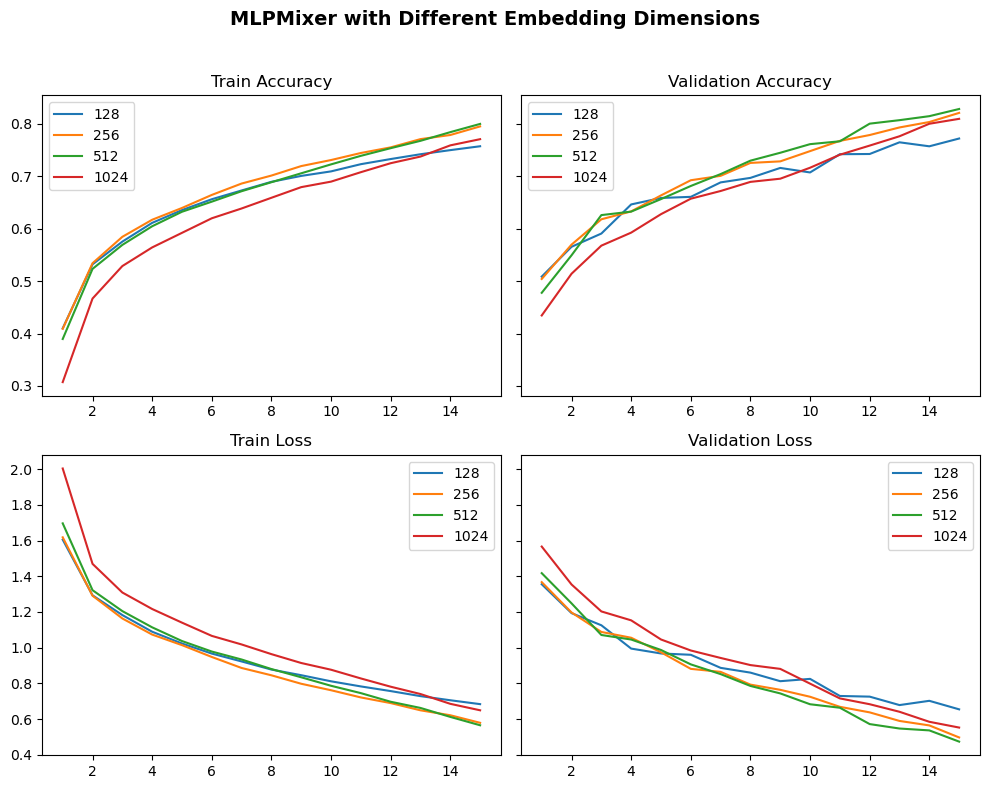

In [18]:
filenames = ['mlpmixer_patch_4_emb_128_results.json', 'mlpmixer_patch_4_results.json', 'mlpmixer_patch_4_emb_512_results.json', 'mlpmixer_patch_4_emb_1024_results.json']
plotnames = ['128', '256', '512', '1024']
# plot_dir = 'plots'
logdir = 'experiments'
save_path = 'plots/mlpmixer_embed_results'

plot_results(logdir, filenames, plotnames=plotnames, save_path=save_path, title='MLPMixer with Different Embedding Dimensions (Patch 4x4)')

# Resnet18 Hyperparameter Tuning:

In [37]:
import itertools

config_path = "./model_configs/resnet18.json"
best_model_path = "./experiments/resnet18_lr_0_001_results.json"

# Define hyperparameter search space
learning_rates = [0.001, 0.0001]  # Small range of LR for tuning
optimizers = ["adam", "adamw", "momentum"]  # Optimizers to test
weight_decays = [5e-4, 1e-4, 1e-3]  # Default + variations

# Generate all possible combinations (Grid Search)
hyperparameter_space = list(itertools.product(learning_rates, optimizers, weight_decays))
# First entry has already been done, this is the default values
hyperparameter_space = hyperparameter_space[1:]

# Run experiments
for i, (lr, optimizer, weight_decay) in enumerate(hyperparameter_space):
    filename = f"resnet18_opt{optimizer}_lr{lr}_wd{weight_decay}_"
    print('-'*100)
    print(f"\nRunning experiment {i+1}/{len(hyperparameter_space)} with: "
          f"lr={lr}, optimizer={optimizer}, weight_decay={weight_decay}")

    # Run training
    subprocess.run([
        "python", "main.py",
        "--model", "resnet18",
        "--model_config", config_path,
        "--filename", filename,
        "--patience", '2',
        "--threshold", '0.02',
        "--best_model_path", best_model_path,
        "--lr", str(lr),
        "--optimizer", optimizer,
        "--weight_decay", str(weight_decay),
        '--epochs', '15',
    ], check=True)
    
    # If the file was created, check if it's better than the current best
    file_path = f'./experiments/{filename}_results.json'
    print(f'File path: {file_path}')
    if os.path.exists(file_path):
        print('\nComparing final validation to best model')
        with open(file_path, "r") as f:
            new_model_data = json.load(f)
        new_final_valid_acc = new_model_data["valid_accs"][-1]

        # Compare to best_model_path
        if os.path.exists(best_model_path):
            with open(best_model_path, "r") as f:
                best_model_data = json.load(f)
            best_final_valid_acc = best_model_data["valid_accs"][-1]
        else:
            best_final_valid_acc = 0

        if new_final_valid_acc > best_final_valid_acc:
            print('\n','='*100)
            print(f"\n\n\nNew best model found. Validation accuracy: {new_final_valid_acc:.4f}\n\n\n")
            best_model_path = file_path
            print('='*100, '\n')
        else:
            print('- Model was not found to have better final validation accuracy than the best model')
    else:
        print("FILE DID NOT EXIST SOMETHING WENT WRONG")

print(f"\n\nBest Model Path: {best_model_path}")

----------------------------------------------------------------------------------------------------

Running experiment 1/17 with: lr=0.001, optimizer=adam, weight_decay=0.0001
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from ./model_configs/resnet18.json
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
 Using adam optimizer with learning rate 0.001.

 A best model path was specified at ./experiments/resnet18_lr_0_001_results.json, using this for early stopping criterion...

====== Epoch 0 ======>


Epoch 0: 100%|██████████| 351/351 [01:55<00:00,  3.03batch/s, acc=0.68, loss=1.01]  


== [TRAIN] Epoch: 0, Accuracy: 0.478, Training Time: 115.906 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.30804
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.589 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.5892578125
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:52<00:00,  3.11batch/s, acc=0.711, loss=0.86] 


== [TRAIN] Epoch: 1, Accuracy: 0.667, Training Time: 112.892 ==
[VAL] Epoch: 1, Iter: 0, Loss: 0.93804
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.672 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.6720703125
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [05:14<00:00,  1.12batch/s, acc=0.711, loss=0.742]  


== [TRAIN] Epoch: 2, Accuracy: 0.745, Training Time: 314.175 ==
[VAL] Epoch: 2, Iter: 0, Loss: 0.98732
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.697 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.696875
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [01:41<00:00,  3.47batch/s, acc=0.766, loss=0.65] 


== [TRAIN] Epoch: 3, Accuracy: 0.788, Training Time: 101.196 ==
[VAL] Epoch: 3, Iter: 0, Loss: 0.72826
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.779 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.7789062500000002
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.844, loss=0.494]


== [TRAIN] Epoch: 4, Accuracy: 0.816, Training Time: 101.857 ==
[VAL] Epoch: 4, Iter: 0, Loss: 0.44518
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.842 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.8416015624999998
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.836, loss=0.468]


== [TRAIN] Epoch: 5, Accuracy: 0.835, Training Time: 101.807 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.40899
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.847 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.847265625
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [01:40<00:00,  3.48batch/s, acc=0.867, loss=0.363]


== [TRAIN] Epoch: 6, Accuracy: 0.854, Training Time: 100.909 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.52995
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.845 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 6 of 0.8447265624999999
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.93, loss=0.218] 


== [TRAIN] Epoch: 7, Accuracy: 0.870, Training Time: 101.350 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.42580
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.870 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.8695312499999998
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.883, loss=0.329]


== [TRAIN] Epoch: 8, Accuracy: 0.877, Training Time: 101.718 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.37238
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.880 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.8798828125000003
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.914, loss=0.241]


== [TRAIN] Epoch: 9, Accuracy: 0.888, Training Time: 101.318 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.25641
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.902 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.9023437500000002
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.93, loss=0.235] 


== [TRAIN] Epoch: 10, Accuracy: 0.899, Training Time: 101.363 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.25004
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.913 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.9128906249999998
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [01:41<00:00,  3.48batch/s, acc=0.93, loss=0.242] 


== [TRAIN] Epoch: 11, Accuracy: 0.906, Training Time: 101.005 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.25947
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.880 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.8802734375
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [01:41<00:00,  3.47batch/s, acc=0.93, loss=0.24]   


== [TRAIN] Epoch: 12, Accuracy: 0.914, Training Time: 101.233 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.26970
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.930 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.930078125
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [01:41<00:00,  3.47batch/s, acc=0.867, loss=0.392] 


== [TRAIN] Epoch: 13, Accuracy: 0.920, Training Time: 101.235 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.25661
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.914 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 13 of 0.9144531249999999
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.922, loss=0.243] 


== [TRAIN] Epoch: 14, Accuracy: 0.925, Training Time: 102.025 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.19147
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.940 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 14 of 0.9400390624999999
[TEST] Epoch: 14, Iter: 0, Loss: 0.29503
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.874 ===>
===== Best validation Accuracy: 0.940 =====>
Writing training logs to experiments...
Saved results to resnet18_optadam_lr0.001_wd0.0001__results.json
File path: ./experiments/resnet18_optadam_lr0.001_wd0.0001__results.json

Comparing final validation to best model
- Model was not found to have better final validation accuracy than the best model
----------------------------------------------------------------------------------------------------

Running experiment 2/17 with: lr=0.001, optimizer=adam, weight_decay=0.001
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and

Epoch 0: 100%|██████████| 351/351 [01:41<00:00,  3.47batch/s, acc=0.68, loss=1.01]  


== [TRAIN] Epoch: 0, Accuracy: 0.478, Training Time: 101.242 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.30804
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.589 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.5892578125
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:41<00:00,  3.47batch/s, acc=0.711, loss=0.86] 


== [TRAIN] Epoch: 1, Accuracy: 0.667, Training Time: 101.039 ==
[VAL] Epoch: 1, Iter: 0, Loss: 0.93804
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.672 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.6720703125
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [01:41<00:00,  3.47batch/s, acc=0.711, loss=0.742]


== [TRAIN] Epoch: 2, Accuracy: 0.745, Training Time: 101.015 ==
[VAL] Epoch: 2, Iter: 0, Loss: 0.98732
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.697 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.696875
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [01:40<00:00,  3.48batch/s, acc=0.766, loss=0.65] 


== [TRAIN] Epoch: 3, Accuracy: 0.788, Training Time: 100.873 ==
[VAL] Epoch: 3, Iter: 0, Loss: 0.72826
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.779 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.7789062500000002
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [01:41<00:00,  3.47batch/s, acc=0.844, loss=0.494]


== [TRAIN] Epoch: 4, Accuracy: 0.816, Training Time: 101.134 ==
[VAL] Epoch: 4, Iter: 0, Loss: 0.44518
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.842 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.8416015624999998
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.836, loss=0.468]


== [TRAIN] Epoch: 5, Accuracy: 0.835, Training Time: 101.400 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.40899
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.847 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.847265625
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [01:41<00:00,  3.47batch/s, acc=0.867, loss=0.363]


== [TRAIN] Epoch: 6, Accuracy: 0.854, Training Time: 101.178 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.52995
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.845 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 6 of 0.8447265624999999
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.93, loss=0.218] 


== [TRAIN] Epoch: 7, Accuracy: 0.870, Training Time: 102.012 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.42580
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.870 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.8695312499999998
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.883, loss=0.329]


== [TRAIN] Epoch: 8, Accuracy: 0.877, Training Time: 101.331 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.37238
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.880 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.8798828125000003
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [01:40<00:00,  3.48batch/s, acc=0.914, loss=0.241]


== [TRAIN] Epoch: 9, Accuracy: 0.888, Training Time: 100.815 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.25641
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.902 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.9023437500000002
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.93, loss=0.235] 


== [TRAIN] Epoch: 10, Accuracy: 0.899, Training Time: 101.336 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.25004
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.913 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.9128906249999998
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.93, loss=0.242] 


== [TRAIN] Epoch: 11, Accuracy: 0.906, Training Time: 101.555 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.25947
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.880 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.8802734375
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.93, loss=0.24]   


== [TRAIN] Epoch: 12, Accuracy: 0.914, Training Time: 101.556 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.26970
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.930 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.930078125
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [01:40<00:00,  3.48batch/s, acc=0.867, loss=0.392] 


== [TRAIN] Epoch: 13, Accuracy: 0.920, Training Time: 100.863 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.25661
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.914 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 13 of 0.9144531249999999
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [01:41<00:00,  3.47batch/s, acc=0.922, loss=0.243] 


== [TRAIN] Epoch: 14, Accuracy: 0.925, Training Time: 101.084 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.19147
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.940 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 14 of 0.9400390624999999
[TEST] Epoch: 14, Iter: 0, Loss: 0.29503
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.874 ===>
===== Best validation Accuracy: 0.940 =====>
Writing training logs to experiments...
Saved results to resnet18_optadam_lr0.001_wd0.001__results.json
File path: ./experiments/resnet18_optadam_lr0.001_wd0.001__results.json

Comparing final validation to best model
- Model was not found to have better final validation accuracy than the best model
----------------------------------------------------------------------------------------------------

Running experiment 3/17 with: lr=0.001, optimizer=adamw, weight_decay=0.0005
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and

Epoch 0: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.672, loss=1]    


== [TRAIN] Epoch: 0, Accuracy: 0.479, Training Time: 101.794 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.43950
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.536 ===>
Validation accuracy of 0.5357421874999998 at epoch 0 is less than the best validation 0.5892578125 - threshold of 0.02
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.711, loss=0.835]


== [TRAIN] Epoch: 1, Accuracy: 0.658, Training Time: 101.632 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.08283
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.638 ===>
Validation accuracy of 0.6382812499999999 at epoch 1 is less than the best validation 0.6720703125 - threshold of 0.02
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 1.06382
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.620 ===>
===== Best validation Accuracy: 0.638 =====>
File path: ./experiments/resnet18_optadamw_lr0.001_wd0.0005__results.json
FILE DID NOT EXIST SOMETHING WENT WRONG
----------------------------------------------------------------------------------------------------

Running experiment 4/17 with: lr=0.001, optimizer=adamw, weight_decay=0.0001
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from ./model_configs/resnet18

Epoch 0: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.688, loss=0.979]


== [TRAIN] Epoch: 0, Accuracy: 0.476, Training Time: 101.744 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.34921
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.563 ===>
Validation accuracy of 0.56328125 at epoch 0 is less than the best validation 0.5892578125 - threshold of 0.02
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.711, loss=0.82] 


== [TRAIN] Epoch: 1, Accuracy: 0.661, Training Time: 101.355 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.03782
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.644 ===>
Validation accuracy of 0.6437499999999999 at epoch 1 is less than the best validation 0.6720703125 - threshold of 0.02
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 1.04335
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.623 ===>
===== Best validation Accuracy: 0.644 =====>
File path: ./experiments/resnet18_optadamw_lr0.001_wd0.0001__results.json
FILE DID NOT EXIST SOMETHING WENT WRONG
----------------------------------------------------------------------------------------------------

Running experiment 5/17 with: lr=0.001, optimizer=adamw, weight_decay=0.001
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from ./model_configs/resnet18.

Epoch 0: 100%|██████████| 351/351 [01:41<00:00,  3.47batch/s, acc=0.672, loss=0.98] 


== [TRAIN] Epoch: 0, Accuracy: 0.480, Training Time: 101.243 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.42307
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.542 ===>
Validation accuracy of 0.5416015624999999 at epoch 0 is less than the best validation 0.5892578125 - threshold of 0.02
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:41<00:00,  3.47batch/s, acc=0.75, loss=0.804] 


== [TRAIN] Epoch: 1, Accuracy: 0.661, Training Time: 101.248 ==
[VAL] Epoch: 1, Iter: 0, Loss: 0.92778
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.678 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.6720703125
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.719, loss=0.712]


== [TRAIN] Epoch: 2, Accuracy: 0.738, Training Time: 101.449 ==
[VAL] Epoch: 2, Iter: 0, Loss: 0.81086
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.715 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.696875
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.758, loss=0.732]


== [TRAIN] Epoch: 3, Accuracy: 0.782, Training Time: 101.688 ==
[VAL] Epoch: 3, Iter: 0, Loss: 0.77405
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.765 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.7789062500000002
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.805, loss=0.503]


== [TRAIN] Epoch: 4, Accuracy: 0.812, Training Time: 101.560 ==
[VAL] Epoch: 4, Iter: 0, Loss: 0.48580
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.832 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.8416015624999998
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.844, loss=0.467]


== [TRAIN] Epoch: 5, Accuracy: 0.832, Training Time: 101.670 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.47328
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.833 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.847265625
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.906, loss=0.31] 


== [TRAIN] Epoch: 6, Accuracy: 0.853, Training Time: 101.653 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.43301
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.862 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 6 of 0.8447265624999999
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.891, loss=0.302]


== [TRAIN] Epoch: 7, Accuracy: 0.865, Training Time: 101.632 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.40526
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.871 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.8695312499999998
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.898, loss=0.303]


== [TRAIN] Epoch: 8, Accuracy: 0.875, Training Time: 102.029 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.34443
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.887 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.8798828125000003
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.867, loss=0.341]


== [TRAIN] Epoch: 9, Accuracy: 0.887, Training Time: 101.847 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.21297
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.898 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.9023437500000002
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [01:41<00:00,  3.47batch/s, acc=0.93, loss=0.233] 


== [TRAIN] Epoch: 10, Accuracy: 0.896, Training Time: 101.181 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.23761
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.911 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.9128906249999998
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.93, loss=0.21]  


== [TRAIN] Epoch: 11, Accuracy: 0.906, Training Time: 102.097 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.36783
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.869 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.8802734375
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.922, loss=0.252]


== [TRAIN] Epoch: 12, Accuracy: 0.910, Training Time: 102.725 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.26087
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.923 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.930078125
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [01:42<00:00,  3.43batch/s, acc=0.891, loss=0.367] 


== [TRAIN] Epoch: 13, Accuracy: 0.918, Training Time: 102.446 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.28539
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.919 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 13 of 0.9144531249999999
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.922, loss=0.216]


== [TRAIN] Epoch: 14, Accuracy: 0.924, Training Time: 102.739 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.17783
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.938 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 14 of 0.9400390624999999
[TEST] Epoch: 14, Iter: 0, Loss: 0.30905
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.873 ===>
===== Best validation Accuracy: 0.938 =====>
Writing training logs to experiments...
Saved results to resnet18_optadamw_lr0.001_wd0.001__results.json
File path: ./experiments/resnet18_optadamw_lr0.001_wd0.001__results.json

Comparing final validation to best model
- Model was not found to have better final validation accuracy than the best model
----------------------------------------------------------------------------------------------------

Running experiment 6/17 with: lr=0.001, optimizer=momentum, weight_decay=0.0005
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloade

Epoch 0: 100%|██████████| 351/351 [01:39<00:00,  3.53batch/s, acc=0.594, loss=1.27]


== [TRAIN] Epoch: 0, Accuracy: 0.421, Training Time: 99.485 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.41554
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.526 ===>
Validation accuracy of 0.5263671874999998 at epoch 0 is less than the best validation 0.5892578125 - threshold of 0.02
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:39<00:00,  3.54batch/s, acc=0.578, loss=1.05] 


== [TRAIN] Epoch: 1, Accuracy: 0.579, Training Time: 99.281 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.11506
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.627 ===>
Validation accuracy of 0.6265625 at epoch 1 is less than the best validation 0.6720703125 - threshold of 0.02
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 1.04305
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.600 ===>
===== Best validation Accuracy: 0.627 =====>
File path: ./experiments/resnet18_optmomentum_lr0.001_wd0.0005__results.json
FILE DID NOT EXIST SOMETHING WENT WRONG
----------------------------------------------------------------------------------------------------

Running experiment 7/17 with: lr=0.001, optimizer=momentum, weight_decay=0.0001
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from ./model_configs/resnet18.jso

Epoch 0: 100%|██████████| 351/351 [01:39<00:00,  3.54batch/s, acc=0.57, loss=1.31] 


== [TRAIN] Epoch: 0, Accuracy: 0.419, Training Time: 99.048 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.46649
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.513 ===>
Validation accuracy of 0.5130859375 at epoch 0 is less than the best validation 0.5892578125 - threshold of 0.02
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:39<00:00,  3.52batch/s, acc=0.539, loss=1.09] 


== [TRAIN] Epoch: 1, Accuracy: 0.580, Training Time: 99.618 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.12223
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.621 ===>
Validation accuracy of 0.6205078124999999 at epoch 1 is less than the best validation 0.6720703125 - threshold of 0.02
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 1.03669
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.604 ===>
===== Best validation Accuracy: 0.621 =====>
File path: ./experiments/resnet18_optmomentum_lr0.001_wd0.0001__results.json
FILE DID NOT EXIST SOMETHING WENT WRONG
----------------------------------------------------------------------------------------------------

Running experiment 8/17 with: lr=0.001, optimizer=momentum, weight_decay=0.001
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from ./model_configs/resn

Epoch 0: 100%|██████████| 351/351 [01:38<00:00,  3.55batch/s, acc=0.586, loss=1.28]


== [TRAIN] Epoch: 0, Accuracy: 0.420, Training Time: 98.860 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.45103
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.520 ===>
Validation accuracy of 0.5197265625 at epoch 0 is less than the best validation 0.5892578125 - threshold of 0.02
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:39<00:00,  3.53batch/s, acc=0.602, loss=1.01] 


== [TRAIN] Epoch: 1, Accuracy: 0.575, Training Time: 99.380 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.11427
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.638 ===>
Validation accuracy of 0.6384765625000002 at epoch 1 is less than the best validation 0.6720703125 - threshold of 0.02
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 0.95313
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.608 ===>
===== Best validation Accuracy: 0.638 =====>
File path: ./experiments/resnet18_optmomentum_lr0.001_wd0.001__results.json
FILE DID NOT EXIST SOMETHING WENT WRONG
----------------------------------------------------------------------------------------------------

Running experiment 9/17 with: lr=0.0001, optimizer=adam, weight_decay=0.0005
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from ./model_configs/resnet1

Epoch 0: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.641, loss=1.04] 


== [TRAIN] Epoch: 0, Accuracy: 0.509, Training Time: 101.769 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.15633
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.616 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.5892578125
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.688, loss=0.842]


== [TRAIN] Epoch: 1, Accuracy: 0.673, Training Time: 101.627 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.04820
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.669 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.6720703125
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [01:42<00:00,  3.43batch/s, acc=0.727, loss=0.741]


== [TRAIN] Epoch: 2, Accuracy: 0.741, Training Time: 102.315 ==
[VAL] Epoch: 2, Iter: 0, Loss: 0.95333
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.721 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.696875
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.75, loss=0.718] 


== [TRAIN] Epoch: 3, Accuracy: 0.784, Training Time: 101.482 ==
[VAL] Epoch: 3, Iter: 0, Loss: 0.71276
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.786 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.7789062500000002
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [01:41<00:00,  3.44batch/s, acc=0.828, loss=0.479]


== [TRAIN] Epoch: 4, Accuracy: 0.809, Training Time: 101.993 ==
[VAL] Epoch: 4, Iter: 0, Loss: 0.52820
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.834 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.8416015624999998
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [01:41<00:00,  3.44batch/s, acc=0.812, loss=0.416]


== [TRAIN] Epoch: 5, Accuracy: 0.830, Training Time: 101.968 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.41900
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.849 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.847265625
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.836, loss=0.479]


== [TRAIN] Epoch: 6, Accuracy: 0.849, Training Time: 102.043 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.47742
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.836 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 6 of 0.8447265624999999
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.922, loss=0.289]


== [TRAIN] Epoch: 7, Accuracy: 0.865, Training Time: 101.567 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.34677
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.866 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.8695312499999998
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.867, loss=0.395]


== [TRAIN] Epoch: 8, Accuracy: 0.875, Training Time: 101.652 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.35338
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.863 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.8798828125000003
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.875, loss=0.369]


== [TRAIN] Epoch: 9, Accuracy: 0.886, Training Time: 102.137 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.20643
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.902 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.9023437500000002
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [01:42<00:00,  3.43batch/s, acc=0.883, loss=0.28] 


== [TRAIN] Epoch: 10, Accuracy: 0.897, Training Time: 102.426 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.27088
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.919 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.9128906249999998
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [01:41<00:00,  3.44batch/s, acc=0.859, loss=0.345]


== [TRAIN] Epoch: 11, Accuracy: 0.905, Training Time: 101.936 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.23620
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.890 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.8802734375
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.914, loss=0.272]


== [TRAIN] Epoch: 12, Accuracy: 0.914, Training Time: 101.488 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.24100
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.928 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.930078125
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.93, loss=0.251] 


== [TRAIN] Epoch: 13, Accuracy: 0.923, Training Time: 101.512 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.25361
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.919 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 13 of 0.9144531249999999
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.945, loss=0.214]


== [TRAIN] Epoch: 14, Accuracy: 0.926, Training Time: 101.824 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.20683
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.936 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 14 of 0.9400390624999999
[TEST] Epoch: 14, Iter: 0, Loss: 0.34437
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.838 ===>
===== Best validation Accuracy: 0.936 =====>
Writing training logs to experiments...
Saved results to resnet18_optadam_lr0.0001_wd0.0005__results.json
File path: ./experiments/resnet18_optadam_lr0.0001_wd0.0005__results.json

Comparing final validation to best model
- Model was not found to have better final validation accuracy than the best model
----------------------------------------------------------------------------------------------------

Running experiment 10/17 with: lr=0.0001, optimizer=adam, weight_decay=0.0001
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloade

Epoch 0: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.641, loss=1.04] 


== [TRAIN] Epoch: 0, Accuracy: 0.509, Training Time: 101.397 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.15633
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.616 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.5892578125
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:41<00:00,  3.47batch/s, acc=0.688, loss=0.842]


== [TRAIN] Epoch: 1, Accuracy: 0.673, Training Time: 101.257 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.04820
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.669 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.6720703125
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [01:41<00:00,  3.44batch/s, acc=0.727, loss=0.741]


== [TRAIN] Epoch: 2, Accuracy: 0.741, Training Time: 101.945 ==
[VAL] Epoch: 2, Iter: 0, Loss: 0.95333
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.721 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.696875
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.75, loss=0.718] 


== [TRAIN] Epoch: 3, Accuracy: 0.784, Training Time: 101.702 ==
[VAL] Epoch: 3, Iter: 0, Loss: 0.71276
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.786 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.7789062500000002
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.828, loss=0.479]


== [TRAIN] Epoch: 4, Accuracy: 0.809, Training Time: 101.556 ==
[VAL] Epoch: 4, Iter: 0, Loss: 0.52820
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.834 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.8416015624999998
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.812, loss=0.416]


== [TRAIN] Epoch: 5, Accuracy: 0.830, Training Time: 101.591 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.41900
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.849 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.847265625
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.836, loss=0.479]


== [TRAIN] Epoch: 6, Accuracy: 0.849, Training Time: 102.110 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.47742
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.836 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 6 of 0.8447265624999999
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.922, loss=0.289]


== [TRAIN] Epoch: 7, Accuracy: 0.865, Training Time: 101.554 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.34677
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.866 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.8695312499999998
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.867, loss=0.395]


== [TRAIN] Epoch: 8, Accuracy: 0.875, Training Time: 102.087 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.35338
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.863 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.8798828125000003
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.875, loss=0.369]


== [TRAIN] Epoch: 9, Accuracy: 0.886, Training Time: 102.046 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.20643
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.902 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.9023437500000002
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.883, loss=0.28] 


== [TRAIN] Epoch: 10, Accuracy: 0.897, Training Time: 101.448 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.27088
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.919 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.9128906249999998
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.859, loss=0.345]


== [TRAIN] Epoch: 11, Accuracy: 0.905, Training Time: 101.812 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.23620
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.890 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.8802734375
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [01:42<00:00,  3.43batch/s, acc=0.914, loss=0.272]


== [TRAIN] Epoch: 12, Accuracy: 0.914, Training Time: 102.215 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.24100
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.928 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.930078125
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.93, loss=0.251] 


== [TRAIN] Epoch: 13, Accuracy: 0.923, Training Time: 101.819 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.25361
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.919 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 13 of 0.9144531249999999
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [01:41<00:00,  3.46batch/s, acc=0.945, loss=0.214]


== [TRAIN] Epoch: 14, Accuracy: 0.926, Training Time: 101.577 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.20683
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.936 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 14 of 0.9400390624999999
[TEST] Epoch: 14, Iter: 0, Loss: 0.34437
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.838 ===>
===== Best validation Accuracy: 0.936 =====>
Writing training logs to experiments...
Saved results to resnet18_optadam_lr0.0001_wd0.0001__results.json
File path: ./experiments/resnet18_optadam_lr0.0001_wd0.0001__results.json

Comparing final validation to best model
- Model was not found to have better final validation accuracy than the best model
----------------------------------------------------------------------------------------------------

Running experiment 11/17 with: lr=0.0001, optimizer=adam, weight_decay=0.001
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded

Epoch 0: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.641, loss=1.04] 


== [TRAIN] Epoch: 0, Accuracy: 0.509, Training Time: 102.522 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.15633
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.616 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.5892578125
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.688, loss=0.842]


== [TRAIN] Epoch: 1, Accuracy: 0.673, Training Time: 101.686 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.04820
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.669 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.6720703125
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.727, loss=0.741]


== [TRAIN] Epoch: 2, Accuracy: 0.741, Training Time: 102.071 ==
[VAL] Epoch: 2, Iter: 0, Loss: 0.95333
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.721 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.696875
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.75, loss=0.718] 


== [TRAIN] Epoch: 3, Accuracy: 0.784, Training Time: 101.883 ==
[VAL] Epoch: 3, Iter: 0, Loss: 0.71276
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.786 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.7789062500000002
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [01:44<00:00,  3.37batch/s, acc=0.828, loss=0.479]


== [TRAIN] Epoch: 4, Accuracy: 0.809, Training Time: 104.162 ==
[VAL] Epoch: 4, Iter: 0, Loss: 0.52820
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.834 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.8416015624999998
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.812, loss=0.416]


== [TRAIN] Epoch: 5, Accuracy: 0.830, Training Time: 101.825 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.41900
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.849 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.847265625
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [01:41<00:00,  3.44batch/s, acc=0.836, loss=0.479]


== [TRAIN] Epoch: 6, Accuracy: 0.849, Training Time: 101.958 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.47742
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.836 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 6 of 0.8447265624999999
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [01:42<00:00,  3.43batch/s, acc=0.922, loss=0.289]


== [TRAIN] Epoch: 7, Accuracy: 0.865, Training Time: 102.192 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.34677
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.866 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.8695312499999998
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.867, loss=0.395]


== [TRAIN] Epoch: 8, Accuracy: 0.875, Training Time: 102.104 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.35338
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.863 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.8798828125000003
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [01:41<00:00,  3.44batch/s, acc=0.875, loss=0.369]


== [TRAIN] Epoch: 9, Accuracy: 0.886, Training Time: 101.927 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.20643
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.902 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.9023437500000002
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.883, loss=0.28] 


== [TRAIN] Epoch: 10, Accuracy: 0.897, Training Time: 101.826 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.27088
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.919 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.9128906249999998
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.859, loss=0.345]


== [TRAIN] Epoch: 11, Accuracy: 0.905, Training Time: 101.869 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.23620
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.890 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.8802734375
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [01:41<00:00,  3.45batch/s, acc=0.914, loss=0.272]


== [TRAIN] Epoch: 12, Accuracy: 0.914, Training Time: 101.659 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.24100
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.928 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.930078125
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.93, loss=0.251] 


== [TRAIN] Epoch: 13, Accuracy: 0.923, Training Time: 102.149 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.25361
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.919 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 13 of 0.9144531249999999
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.945, loss=0.214]


== [TRAIN] Epoch: 14, Accuracy: 0.926, Training Time: 102.019 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.20683
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.936 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 14 of 0.9400390624999999
[TEST] Epoch: 14, Iter: 0, Loss: 0.34437
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.838 ===>
===== Best validation Accuracy: 0.936 =====>
Writing training logs to experiments...
Saved results to resnet18_optadam_lr0.0001_wd0.001__results.json
File path: ./experiments/resnet18_optadam_lr0.0001_wd0.001__results.json

Comparing final validation to best model
- Model was not found to have better final validation accuracy than the best model
----------------------------------------------------------------------------------------------------

Running experiment 12/17 with: lr=0.0001, optimizer=adamw, weight_decay=0.0005
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded

Epoch 0: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.648, loss=1.05] 


== [TRAIN] Epoch: 0, Accuracy: 0.510, Training Time: 102.683 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.18296
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.607 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.5892578125
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:42<00:00,  3.43batch/s, acc=0.711, loss=0.826]


== [TRAIN] Epoch: 1, Accuracy: 0.670, Training Time: 102.458 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.00441
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.682 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.6720703125
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [01:42<00:00,  3.41batch/s, acc=0.742, loss=0.761]


== [TRAIN] Epoch: 2, Accuracy: 0.739, Training Time: 102.791 ==
[VAL] Epoch: 2, Iter: 0, Loss: 0.87838
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.722 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.696875
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.75, loss=0.734] 


== [TRAIN] Epoch: 3, Accuracy: 0.782, Training Time: 102.655 ==
[VAL] Epoch: 3, Iter: 0, Loss: 0.72099
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.792 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.7789062500000002
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.828, loss=0.526]


== [TRAIN] Epoch: 4, Accuracy: 0.809, Training Time: 102.500 ==
[VAL] Epoch: 4, Iter: 0, Loss: 0.46758
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.831 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.8416015624999998
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [01:43<00:00,  3.40batch/s, acc=0.844, loss=0.443]


== [TRAIN] Epoch: 5, Accuracy: 0.830, Training Time: 103.137 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.42878
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.842 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.847265625
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.859, loss=0.438]


== [TRAIN] Epoch: 6, Accuracy: 0.849, Training Time: 102.005 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.38582
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.861 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 6 of 0.8447265624999999
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.898, loss=0.315]


== [TRAIN] Epoch: 7, Accuracy: 0.861, Training Time: 102.506 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.38651
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.867 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.8695312499999998
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [01:42<00:00,  3.41batch/s, acc=0.883, loss=0.411]


== [TRAIN] Epoch: 8, Accuracy: 0.875, Training Time: 102.926 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.38959
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.872 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.8798828125000003
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [01:42<00:00,  3.43batch/s, acc=0.883, loss=0.341]


== [TRAIN] Epoch: 9, Accuracy: 0.885, Training Time: 102.270 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.23490
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.887 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.9023437500000002
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.891, loss=0.251]


== [TRAIN] Epoch: 10, Accuracy: 0.897, Training Time: 102.680 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.30005
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.905 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.9128906249999998
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.883, loss=0.317]


== [TRAIN] Epoch: 11, Accuracy: 0.905, Training Time: 102.547 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.21985
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.884 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.8802734375
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.922, loss=0.246]


== [TRAIN] Epoch: 12, Accuracy: 0.913, Training Time: 102.719 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.23491
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.926 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.930078125
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.922, loss=0.264]


== [TRAIN] Epoch: 13, Accuracy: 0.922, Training Time: 102.669 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.18029
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.944 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 13 of 0.9144531249999999
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [01:42<00:00,  3.41batch/s, acc=0.969, loss=0.166]


== [TRAIN] Epoch: 14, Accuracy: 0.925, Training Time: 102.887 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.21827
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.946 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 14 of 0.9400390624999999
[TEST] Epoch: 14, Iter: 0, Loss: 0.26908
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.851 ===>
===== Best validation Accuracy: 0.946 =====>
Writing training logs to experiments...
Saved results to resnet18_optadamw_lr0.0001_wd0.0005__results.json
File path: ./experiments/resnet18_optadamw_lr0.0001_wd0.0005__results.json

Comparing final validation to best model




New best model found. Validation accuracy: 0.9461




----------------------------------------------------------------------------------------------------

Running experiment 13/17 with: lr=0.0001, optimizer=adamw, weight_decay=0.0001
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build m

Epoch 0: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.641, loss=1.04] 


== [TRAIN] Epoch: 0, Accuracy: 0.509, Training Time: 102.528 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.15633
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.616 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.6068359375
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:42<00:00,  3.43batch/s, acc=0.688, loss=0.842]


== [TRAIN] Epoch: 1, Accuracy: 0.673, Training Time: 102.286 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.04820
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.669 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.6818359375000002
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [01:41<00:00,  3.44batch/s, acc=0.727, loss=0.741]


== [TRAIN] Epoch: 2, Accuracy: 0.741, Training Time: 101.935 ==
[VAL] Epoch: 2, Iter: 0, Loss: 0.95333
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.721 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.7218750000000002
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [01:42<00:00,  3.41batch/s, acc=0.75, loss=0.718] 


== [TRAIN] Epoch: 3, Accuracy: 0.784, Training Time: 102.893 ==
[VAL] Epoch: 3, Iter: 0, Loss: 0.71276
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.786 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.7916015625
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [01:42<00:00,  3.43batch/s, acc=0.828, loss=0.479]


== [TRAIN] Epoch: 4, Accuracy: 0.809, Training Time: 102.375 ==
[VAL] Epoch: 4, Iter: 0, Loss: 0.52820
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.834 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.8306640625
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.812, loss=0.416]


== [TRAIN] Epoch: 5, Accuracy: 0.830, Training Time: 102.538 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.41900
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.849 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.8421875
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.836, loss=0.479]


== [TRAIN] Epoch: 6, Accuracy: 0.849, Training Time: 102.629 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.47742
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.836 ===>
Validation accuracy of 0.8361328124999999 at epoch 6 is less than the best validation 0.861328125 - threshold of 0.02
No improvement for 1 epoch(s).
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [01:43<00:00,  3.39batch/s, acc=0.922, loss=0.289]


== [TRAIN] Epoch: 7, Accuracy: 0.865, Training Time: 103.423 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.34677
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.866 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.8671875
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [01:43<00:00,  3.40batch/s, acc=0.867, loss=0.395]


== [TRAIN] Epoch: 8, Accuracy: 0.875, Training Time: 103.337 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.35338
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.863 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.8718750000000002
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.875, loss=0.369]


== [TRAIN] Epoch: 9, Accuracy: 0.886, Training Time: 102.507 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.20643
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.902 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.8869140625
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [01:42<00:00,  3.43batch/s, acc=0.883, loss=0.28] 


== [TRAIN] Epoch: 10, Accuracy: 0.897, Training Time: 102.337 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.27088
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.919 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.9054687499999999
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [01:43<00:00,  3.41batch/s, acc=0.859, loss=0.345]


== [TRAIN] Epoch: 11, Accuracy: 0.905, Training Time: 103.018 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.23620
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.890 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.8843750000000001
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.914, loss=0.272]


== [TRAIN] Epoch: 12, Accuracy: 0.914, Training Time: 102.691 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.24100
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.928 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.9259765625000002
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [01:42<00:00,  3.41batch/s, acc=0.93, loss=0.251] 


== [TRAIN] Epoch: 13, Accuracy: 0.923, Training Time: 102.793 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.25361
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.919 ===>
Validation accuracy of 0.9189453124999999 at epoch 13 is less than the best validation 0.9437499999999998 - threshold of 0.02
No improvement for 2 epoch(s).
Early stopping triggered after 14 epochs due to lack of improvement.
[TEST] Epoch: 13, Iter: 0, Loss: 0.30059
=== [TEST] Epoch: 13, Iter: 78, Accuracy: 0.827 ===>
===== Best validation Accuracy: 0.928 =====>
File path: ./experiments/resnet18_optadamw_lr0.0001_wd0.0001__results.json
FILE DID NOT EXIST SOMETHING WENT WRONG
----------------------------------------------------------------------------------------------------

Running experiment 14/17 with: lr=0.0001, optimizer=adamw, weight_decay=0.001
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from ./model_c

Epoch 0: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.609, loss=1.11] 


== [TRAIN] Epoch: 0, Accuracy: 0.509, Training Time: 102.685 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.18872
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.606 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.6068359375
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.711, loss=0.818]


== [TRAIN] Epoch: 1, Accuracy: 0.669, Training Time: 102.584 ==
[VAL] Epoch: 1, Iter: 0, Loss: 0.96829
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.688 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.6818359375000002
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.719, loss=0.802]


== [TRAIN] Epoch: 2, Accuracy: 0.737, Training Time: 102.620 ==
[VAL] Epoch: 2, Iter: 0, Loss: 0.80680
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.715 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.7218750000000002
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.75, loss=0.745] 


== [TRAIN] Epoch: 3, Accuracy: 0.783, Training Time: 102.101 ==
[VAL] Epoch: 3, Iter: 0, Loss: 0.56123
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.790 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.7916015625
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.828, loss=0.537]


== [TRAIN] Epoch: 4, Accuracy: 0.810, Training Time: 102.157 ==
[VAL] Epoch: 4, Iter: 0, Loss: 0.50866
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.835 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.8306640625
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.852, loss=0.425]


== [TRAIN] Epoch: 5, Accuracy: 0.829, Training Time: 102.534 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.45101
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.853 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.8421875
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [01:42<00:00,  3.44batch/s, acc=0.828, loss=0.499]


== [TRAIN] Epoch: 6, Accuracy: 0.847, Training Time: 102.057 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.48017
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.843 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 6 of 0.861328125
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [01:42<00:00,  3.43batch/s, acc=0.93, loss=0.264] 


== [TRAIN] Epoch: 7, Accuracy: 0.865, Training Time: 102.214 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.43039
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.872 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.8671875
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [01:42<00:00,  3.41batch/s, acc=0.891, loss=0.353]


== [TRAIN] Epoch: 8, Accuracy: 0.874, Training Time: 102.857 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.45059
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.855 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.8718750000000002
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.859, loss=0.346]


== [TRAIN] Epoch: 9, Accuracy: 0.886, Training Time: 102.552 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.23468
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.886 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.8869140625
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.93, loss=0.203] 


== [TRAIN] Epoch: 10, Accuracy: 0.897, Training Time: 102.497 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.30545
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.909 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.9054687499999999
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [01:42<00:00,  3.41batch/s, acc=0.875, loss=0.295]


== [TRAIN] Epoch: 11, Accuracy: 0.905, Training Time: 102.866 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.23701
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.907 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.8843750000000001
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [01:42<00:00,  3.43batch/s, acc=0.906, loss=0.289]


== [TRAIN] Epoch: 12, Accuracy: 0.913, Training Time: 102.292 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.29506
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.925 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.9259765625000002
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [01:42<00:00,  3.43batch/s, acc=0.93, loss=0.225] 


== [TRAIN] Epoch: 13, Accuracy: 0.923, Training Time: 102.359 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.23324
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.928 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 13 of 0.9437499999999998
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [01:42<00:00,  3.42batch/s, acc=0.914, loss=0.261]


== [TRAIN] Epoch: 14, Accuracy: 0.925, Training Time: 102.643 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.19566
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.940 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 14 of 0.9460937500000001
[TEST] Epoch: 14, Iter: 0, Loss: 0.35681
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.845 ===>
===== Best validation Accuracy: 0.940 =====>
Writing training logs to experiments...
Saved results to resnet18_optadamw_lr0.0001_wd0.001__results.json
File path: ./experiments/resnet18_optadamw_lr0.0001_wd0.001__results.json

Comparing final validation to best model
- Model was not found to have better final validation accuracy than the best model
----------------------------------------------------------------------------------------------------

Running experiment 15/17 with: lr=0.0001, optimizer=momentum, weight_decay=0.0005
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downl

Epoch 0: 100%|██████████| 351/351 [01:39<00:00,  3.53batch/s, acc=0.359, loss=1.83]


== [TRAIN] Epoch: 0, Accuracy: 0.262, Training Time: 99.348 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.93986
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.339 ===>
Validation accuracy of 0.33925781250000003 at epoch 0 is less than the best validation 0.6068359375 - threshold of 0.02
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:39<00:00,  3.53batch/s, acc=0.398, loss=1.64]


== [TRAIN] Epoch: 1, Accuracy: 0.376, Training Time: 99.455 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.75213
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.413 ===>
Validation accuracy of 0.4128906249999999 at epoch 1 is less than the best validation 0.6818359375000002 - threshold of 0.02
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 1.54296
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.417 ===>
===== Best validation Accuracy: 0.413 =====>
File path: ./experiments/resnet18_optmomentum_lr0.0001_wd0.0005__results.json
FILE DID NOT EXIST SOMETHING WENT WRONG
----------------------------------------------------------------------------------------------------

Running experiment 16/17 with: lr=0.0001, optimizer=momentum, weight_decay=0.0001
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from ./model_co

Epoch 0: 100%|██████████| 351/351 [01:38<00:00,  3.55batch/s, acc=0.375, loss=1.82]


== [TRAIN] Epoch: 0, Accuracy: 0.262, Training Time: 98.947 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.94437
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.340 ===>
Validation accuracy of 0.34023437500000003 at epoch 0 is less than the best validation 0.6068359375 - threshold of 0.02
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:39<00:00,  3.54batch/s, acc=0.398, loss=1.64]


== [TRAIN] Epoch: 1, Accuracy: 0.378, Training Time: 99.077 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.74456
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.421 ===>
Validation accuracy of 0.4207031250000001 at epoch 1 is less than the best validation 0.6818359375000002 - threshold of 0.02
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 1.53366
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.415 ===>
===== Best validation Accuracy: 0.421 =====>
File path: ./experiments/resnet18_optmomentum_lr0.0001_wd0.0001__results.json
FILE DID NOT EXIST SOMETHING WENT WRONG
----------------------------------------------------------------------------------------------------

Running experiment 17/17 with: lr=0.0001, optimizer=momentum, weight_decay=0.001
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from ./model_con

Epoch 0: 100%|██████████| 351/351 [01:39<00:00,  3.54batch/s, acc=0.336, loss=1.84]


== [TRAIN] Epoch: 0, Accuracy: 0.261, Training Time: 99.098 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.94709
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.338 ===>
Validation accuracy of 0.33828125000000003 at epoch 0 is less than the best validation 0.6068359375 - threshold of 0.02
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:40<00:00,  3.50batch/s, acc=0.391, loss=1.64]


== [TRAIN] Epoch: 1, Accuracy: 0.378, Training Time: 100.313 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.74750
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.419 ===>
Validation accuracy of 0.4187500000000001 at epoch 1 is less than the best validation 0.6818359375000002 - threshold of 0.02
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 1.54442
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.416 ===>
===== Best validation Accuracy: 0.419 =====>
File path: ./experiments/resnet18_optmomentum_lr0.0001_wd0.001__results.json
FILE DID NOT EXIST SOMETHING WENT WRONG


Best Model Path: ./experiments/resnet18_optadamw_lr0.0001_wd0.0005__results.json


# MLPMixer Hyperparameter Tuning

In [38]:
import random

config_path = "./model_configs/mlpmixer.json"
best_model_path = "./experiments/mlpmixer_patch_4_results.json"

# Define hyperparameter search space
learning_rates = [0.001, 0.0001]  # Small range of LR for tuning
optimizers = ["adam", "adamw", "momentum"]
drop_rates = [0, 0, 0.25, 0.5]  # Use 0 twice to keep it balanced in sampling
num_blocks_list = [4, 5, 6]  # From 4 to 6 (not smaller than 4)

# Generate all possible combinations
hyperparameter_space = [
    {
        "lr": lr,
        "optimizer": opt,
        "drop_rate": dr,
        "num_blocks": nb
    }
    for lr in learning_rates
    for opt in optimizers
    for dr in drop_rates
    for nb in num_blocks_list
]

# Randomly sample 20 configurations
random.seed(42)  # For reproducibility
selected_combinations = random.sample(hyperparameter_space, 20)

# Run experiments
for i, params in enumerate(selected_combinations):
    lr = params["lr"]
    optimizer = params["optimizer"]
    drop_rate = params["drop_rate"]
    num_blocks = params["num_blocks"]

    filename = f"mlpmixer_ps4_emb_256_opt{optimizer}_dr{drop_rate}_nb{num_blocks}_lr{lr}"

    print(f"\nRunning experiment {i+1}/20 with: "
          f"lr={lr}, optimizer={optimizer}, drop_rate={drop_rate}, num_blocks={num_blocks}")

    # Modify the JSON config
    with open(config_path, "r") as f:
        config = json.load(f)

    config["patch_size"] = 4  # Fixed
    config["embed_dim"] = 256  # Fixed
    config["drop_rate"] = drop_rate
    config["num_blocks"] = num_blocks

    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)

    # Run training
    subprocess.run([
        "python", "main.py",
        "--model", "mlpmixer",
        "--model_config", config_path,
        "--filename", filename,
        "--patience", '2',
        "--threshold", '0.05',
        "--best_model_path", best_model_path,
        "--lr", str(lr),
        "--optimizer", optimizer
    ], check=True)

    # If the file was created, check if it's better than the current best
    file_path = f'./experiments/{filename}_results.json'
    print(f'File path: {file_path}')
    if os.path.exists(file_path):
        print('\nComparing final validation to best model')
        with open(file_path, "r") as f:
            new_model_data = json.load(f)
        new_final_valid_acc = new_model_data["valid_accs"][-1]

        # Compare to best_model_path
        if os.path.exists(best_model_path):
            with open(best_model_path, "r") as f:
                best_model_data = json.load(f)
            best_final_valid_acc = best_model_data["valid_accs"][-1]
        else:
            best_final_valid_acc = 0
        
        if new_final_valid_acc > best_final_valid_acc:
            print('\n','='*100)
            print(f"\n\n\nNew best model found. Validation accuracy: {new_final_valid_acc:.4f}\n\n\n")
            best_model_path = file_path
            print('='*100, '\n')
            
        else:
            print('- Model was not found to have better final validation accuracy than the best model')
    else:
        print("FILE DID NOT EXIST SOMETHING WENT WRONG")

print(f"\n\nBest Model Path: {best_model_path}")



Running experiment 1/20 with: lr=0.001, optimizer=adamw, drop_rate=0, num_blocks=6
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 3274634 total parameters, of which 3274634 are learnable.
 Using adamw optimizer with learning rate 0.001.

 A best model path was specified at ./experiments/mlpmixer_patch_4_results.json, using this for early stopping criterion...

====== Epoch 0 ======>


Epoch 0: 100%|██████████| 351/351 [01:09<00:00,  5.03batch/s, acc=0.469, loss=1.49]


== [TRAIN] Epoch: 0, Accuracy: 0.402, Training Time: 69.789 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.46160
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.489 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.50390625
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:10<00:00,  4.98batch/s, acc=0.602, loss=1.16] 


== [TRAIN] Epoch: 1, Accuracy: 0.536, Training Time: 70.488 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.33498
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.583 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.5693359374999999
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [01:09<00:00,  5.02batch/s, acc=0.68, loss=0.985] 


== [TRAIN] Epoch: 2, Accuracy: 0.594, Training Time: 69.856 ==
[VAL] Epoch: 2, Iter: 0, Loss: 1.26088
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.602 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.6175781249999999
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [01:10<00:00,  5.01batch/s, acc=0.68, loss=0.896] 


== [TRAIN] Epoch: 3, Accuracy: 0.625, Training Time: 70.024 ==
[VAL] Epoch: 3, Iter: 0, Loss: 0.99251
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.665 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.6326171875000001
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [01:11<00:00,  4.89batch/s, acc=0.727, loss=0.807]


== [TRAIN] Epoch: 4, Accuracy: 0.658, Training Time: 71.796 ==
[VAL] Epoch: 4, Iter: 0, Loss: 1.01721
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.666 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.6630859375000002
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [01:10<00:00,  5.01batch/s, acc=0.711, loss=0.804]


== [TRAIN] Epoch: 5, Accuracy: 0.675, Training Time: 70.052 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.84587
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.716 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.6919921875000001
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [01:10<00:00,  4.98batch/s, acc=0.719, loss=0.795]


== [TRAIN] Epoch: 6, Accuracy: 0.698, Training Time: 70.494 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.96447
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.704 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 6 of 0.7003906249999999
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [01:10<00:00,  4.99batch/s, acc=0.68, loss=0.892] 


== [TRAIN] Epoch: 7, Accuracy: 0.717, Training Time: 70.359 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.81677
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.751 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.725
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [01:09<00:00,  5.02batch/s, acc=0.688, loss=0.875]


== [TRAIN] Epoch: 8, Accuracy: 0.735, Training Time: 69.945 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.77915
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.753 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.7279296875000002
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [01:10<00:00,  4.96batch/s, acc=0.781, loss=0.618]


== [TRAIN] Epoch: 9, Accuracy: 0.748, Training Time: 70.755 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.70309
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.771 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.7474609375000001
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [01:10<00:00,  4.99batch/s, acc=0.758, loss=0.671]


== [TRAIN] Epoch: 10, Accuracy: 0.764, Training Time: 70.372 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.69432
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.788 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.7669921875000002
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [01:10<00:00,  5.00batch/s, acc=0.797, loss=0.58] 


== [TRAIN] Epoch: 11, Accuracy: 0.779, Training Time: 70.167 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.65804
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.806 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.7781250000000001
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [01:09<00:00,  5.03batch/s, acc=0.766, loss=0.538]


== [TRAIN] Epoch: 12, Accuracy: 0.794, Training Time: 69.815 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.54891
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.825 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.792578125
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [01:10<00:00,  4.96batch/s, acc=0.789, loss=0.604]


== [TRAIN] Epoch: 13, Accuracy: 0.810, Training Time: 70.788 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.54935
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.843 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 13 of 0.8029296874999999
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [01:10<00:00,  5.00batch/s, acc=0.789, loss=0.639]


== [TRAIN] Epoch: 14, Accuracy: 0.823, Training Time: 70.139 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.51585
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.834 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 14 of 0.8203125000000001
[TEST] Epoch: 14, Iter: 0, Loss: 0.64806
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.721 ===>
===== Best validation Accuracy: 0.843 =====>
Writing training logs to experiments...
Saved results to mlpmixer_ps4_emb_256_optadamw_dr0_nb6_lr0.001_results.json
File path: ./experiments/mlpmixer_ps4_emb_256_optadamw_dr0_nb6_lr0.001_results.json

Comparing final validation to best model




New best model found. Validation accuracy: 0.8336





Running experiment 2/20 with: lr=0.001, optimizer=adam, drop_rate=0, num_blocks=4
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initiali

Epoch 0: 100%|██████████| 351/351 [00:57<00:00,  6.15batch/s, acc=0.523, loss=1.4] 


== [TRAIN] Epoch: 0, Accuracy: 0.409, Training Time: 57.089 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.44316
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.504 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.4894531250000001
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [00:57<00:00,  6.12batch/s, acc=0.539, loss=1.28]


== [TRAIN] Epoch: 1, Accuracy: 0.534, Training Time: 57.389 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.32773
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.569 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.5828125000000001
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [00:57<00:00,  6.12batch/s, acc=0.516, loss=1.19] 


== [TRAIN] Epoch: 2, Accuracy: 0.584, Training Time: 57.328 ==
[VAL] Epoch: 2, Iter: 0, Loss: 1.19211
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.618 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.6019531249999999
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [00:57<00:00,  6.11batch/s, acc=0.625, loss=1.06] 


== [TRAIN] Epoch: 3, Accuracy: 0.617, Training Time: 57.409 ==
[VAL] Epoch: 3, Iter: 0, Loss: 1.18691
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.633 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.6646484375000001
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [00:58<00:00,  6.03batch/s, acc=0.688, loss=0.92] 


== [TRAIN] Epoch: 4, Accuracy: 0.639, Training Time: 58.183 ==
[VAL] Epoch: 4, Iter: 0, Loss: 1.15790
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.663 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.6660156249999999
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [00:57<00:00,  6.12batch/s, acc=0.672, loss=0.914]


== [TRAIN] Epoch: 5, Accuracy: 0.664, Training Time: 57.351 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.99916
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.692 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.7160156249999999
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [00:57<00:00,  6.13batch/s, acc=0.672, loss=0.967]


== [TRAIN] Epoch: 6, Accuracy: 0.686, Training Time: 57.248 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.98368
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.700 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 6 of 0.7039062500000001
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [00:57<00:00,  6.11batch/s, acc=0.719, loss=0.897]


== [TRAIN] Epoch: 7, Accuracy: 0.701, Training Time: 57.428 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.82014
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.725 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.7513671875
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [00:57<00:00,  6.09batch/s, acc=0.727, loss=0.846]


== [TRAIN] Epoch: 8, Accuracy: 0.719, Training Time: 57.673 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.76470
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.728 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.7527343750000001
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [00:57<00:00,  6.15batch/s, acc=0.719, loss=0.833]


== [TRAIN] Epoch: 9, Accuracy: 0.730, Training Time: 57.051 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.73781
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.747 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.7714843750000002
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [00:57<00:00,  6.13batch/s, acc=0.727, loss=0.791]


== [TRAIN] Epoch: 10, Accuracy: 0.744, Training Time: 57.230 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.71077
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.767 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.7880859375000001
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [00:57<00:00,  6.10batch/s, acc=0.68, loss=0.857] 


== [TRAIN] Epoch: 11, Accuracy: 0.755, Training Time: 57.552 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.77943
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.778 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.8064453124999998
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [00:57<00:00,  6.16batch/s, acc=0.766, loss=0.605]


== [TRAIN] Epoch: 12, Accuracy: 0.770, Training Time: 57.020 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.64186
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.793 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.8251953125
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [00:57<00:00,  6.13batch/s, acc=0.859, loss=0.436]


== [TRAIN] Epoch: 13, Accuracy: 0.778, Training Time: 57.264 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.58669
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.803 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 13 of 0.8427734375000001
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [00:57<00:00,  6.10batch/s, acc=0.852, loss=0.555]


== [TRAIN] Epoch: 14, Accuracy: 0.795, Training Time: 57.501 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.55967
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.820 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 14 of 0.83359375
[TEST] Epoch: 14, Iter: 0, Loss: 0.64321
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.726 ===>
===== Best validation Accuracy: 0.820 =====>
Writing training logs to experiments...
Saved results to mlpmixer_ps4_emb_256_optadam_dr0_nb4_lr0.001_results.json
File path: ./experiments/mlpmixer_ps4_emb_256_optadam_dr0_nb4_lr0.001_results.json

Comparing final validation to best model
- Model was not found to have better final validation accuracy than the best model

Running experiment 3/20 with: lr=0.001, optimizer=momentum, drop_rate=0.5, num_blocks=6
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/m

Epoch 0: 100%|██████████| 351/351 [01:21<00:00,  4.29batch/s, acc=0.219, loss=2.09]


== [TRAIN] Epoch: 0, Accuracy: 0.184, Training Time: 81.794 ==
[VAL] Epoch: 0, Iter: 0, Loss: 2.10791
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.230 ===>
Validation accuracy of 0.22988281249999998 at epoch 0 is less than the best validation 0.4894531250000001 - threshold of 0.05
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:21<00:00,  4.29batch/s, acc=0.242, loss=1.97]


== [TRAIN] Epoch: 1, Accuracy: 0.229, Training Time: 81.878 ==
[VAL] Epoch: 1, Iter: 0, Loss: 2.15555
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.250 ===>
Validation accuracy of 0.24960937499999997 at epoch 1 is less than the best validation 0.5828125000000001 - threshold of 0.05
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 2.04133
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.253 ===>
===== Best validation Accuracy: 0.250 =====>
File path: ./experiments/mlpmixer_ps4_emb_256_optmomentum_dr0.5_nb6_lr0.001_results.json
FILE DID NOT EXIST SOMETHING WENT WRONG

Running experiment 4/20 with: lr=0.001, optimizer=momentum, drop_rate=0.25, num_blocks=5
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 2731466 total parameters, of w

Epoch 0: 100%|██████████| 351/351 [01:12<00:00,  4.83batch/s, acc=0.195, loss=2.03]


== [TRAIN] Epoch: 0, Accuracy: 0.213, Training Time: 72.714 ==
[VAL] Epoch: 0, Iter: 0, Loss: 2.01622
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.253 ===>
Validation accuracy of 0.25253906249999997 at epoch 0 is less than the best validation 0.4894531250000001 - threshold of 0.05
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:13<00:00,  4.78batch/s, acc=0.234, loss=2]   


== [TRAIN] Epoch: 1, Accuracy: 0.255, Training Time: 73.381 ==
[VAL] Epoch: 1, Iter: 0, Loss: 2.01680
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.275 ===>
Validation accuracy of 0.274609375 at epoch 1 is less than the best validation 0.5828125000000001 - threshold of 0.05
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 1.87430
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.280 ===>
===== Best validation Accuracy: 0.275 =====>
File path: ./experiments/mlpmixer_ps4_emb_256_optmomentum_dr0.25_nb5_lr0.001_results.json
FILE DID NOT EXIST SOMETHING WENT WRONG

Running experiment 5/20 with: lr=0.001, optimizer=momentum, drop_rate=0, num_blocks=5
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 2731466 total parameters, of which 27314

Epoch 0: 100%|██████████| 351/351 [01:02<00:00,  5.59batch/s, acc=0.266, loss=1.94]


== [TRAIN] Epoch: 0, Accuracy: 0.247, Training Time: 62.844 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.98504
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.296 ===>
Validation accuracy of 0.29648437499999997 at epoch 0 is less than the best validation 0.4894531250000001 - threshold of 0.05
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:03<00:00,  5.53batch/s, acc=0.297, loss=1.87]


== [TRAIN] Epoch: 1, Accuracy: 0.308, Training Time: 63.440 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.93131
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.338 ===>
Validation accuracy of 0.3375000000000001 at epoch 1 is less than the best validation 0.5828125000000001 - threshold of 0.05
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 1.75115
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.333 ===>
===== Best validation Accuracy: 0.338 =====>
File path: ./experiments/mlpmixer_ps4_emb_256_optmomentum_dr0_nb5_lr0.001_results.json
FILE DID NOT EXIST SOMETHING WENT WRONG

Running experiment 6/20 with: lr=0.001, optimizer=adamw, drop_rate=0, num_blocks=6
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 3274634 total parameters, of which 3274

Epoch 0: 100%|██████████| 351/351 [01:09<00:00,  5.04batch/s, acc=0.469, loss=1.49]


== [TRAIN] Epoch: 0, Accuracy: 0.402, Training Time: 69.637 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.46160
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.489 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.4894531250000001
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:10<00:00,  4.96batch/s, acc=0.602, loss=1.16] 


== [TRAIN] Epoch: 1, Accuracy: 0.536, Training Time: 70.726 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.33498
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.583 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.5828125000000001
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [01:10<00:00,  4.96batch/s, acc=0.68, loss=0.985] 


== [TRAIN] Epoch: 2, Accuracy: 0.594, Training Time: 70.771 ==
[VAL] Epoch: 2, Iter: 0, Loss: 1.26088
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.602 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.6019531249999999
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [01:10<00:00,  4.99batch/s, acc=0.68, loss=0.896] 


== [TRAIN] Epoch: 3, Accuracy: 0.625, Training Time: 70.283 ==
[VAL] Epoch: 3, Iter: 0, Loss: 0.99251
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.665 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.6646484375000001
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [01:09<00:00,  5.02batch/s, acc=0.727, loss=0.807]


== [TRAIN] Epoch: 4, Accuracy: 0.658, Training Time: 69.953 ==
[VAL] Epoch: 4, Iter: 0, Loss: 1.01721
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.666 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.6660156249999999
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [01:09<00:00,  5.02batch/s, acc=0.711, loss=0.804]


== [TRAIN] Epoch: 5, Accuracy: 0.675, Training Time: 69.887 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.84587
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.716 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.7160156249999999
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [01:09<00:00,  5.03batch/s, acc=0.719, loss=0.795]


== [TRAIN] Epoch: 6, Accuracy: 0.698, Training Time: 69.777 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.96447
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.704 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 6 of 0.7039062500000001
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [01:10<00:00,  4.98batch/s, acc=0.68, loss=0.892] 


== [TRAIN] Epoch: 7, Accuracy: 0.717, Training Time: 70.498 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.81677
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.751 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.7513671875
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [01:09<00:00,  5.02batch/s, acc=0.688, loss=0.875]


== [TRAIN] Epoch: 8, Accuracy: 0.735, Training Time: 69.940 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.77915
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.753 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.7527343750000001
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [01:10<00:00,  4.99batch/s, acc=0.781, loss=0.618]


== [TRAIN] Epoch: 9, Accuracy: 0.748, Training Time: 70.290 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.70309
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.771 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.7714843750000002
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [01:09<00:00,  5.02batch/s, acc=0.758, loss=0.671]


== [TRAIN] Epoch: 10, Accuracy: 0.764, Training Time: 69.968 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.69432
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.788 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.7880859375000001
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [01:10<00:00,  4.95batch/s, acc=0.797, loss=0.58] 


== [TRAIN] Epoch: 11, Accuracy: 0.779, Training Time: 70.864 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.65804
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.806 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.8064453124999998
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [01:09<00:00,  5.03batch/s, acc=0.766, loss=0.538]


== [TRAIN] Epoch: 12, Accuracy: 0.794, Training Time: 69.802 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.54891
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.825 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.8251953125
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [01:09<00:00,  5.02batch/s, acc=0.789, loss=0.604]


== [TRAIN] Epoch: 13, Accuracy: 0.810, Training Time: 69.943 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.54935
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.843 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 13 of 0.8427734375000001
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [01:10<00:00,  4.97batch/s, acc=0.789, loss=0.639]


== [TRAIN] Epoch: 14, Accuracy: 0.823, Training Time: 70.558 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.51585
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.834 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 14 of 0.83359375
[TEST] Epoch: 14, Iter: 0, Loss: 0.64806
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.721 ===>
===== Best validation Accuracy: 0.843 =====>
Writing training logs to experiments...
Saved results to mlpmixer_ps4_emb_256_optadamw_dr0_nb6_lr0.001_results.json
File path: ./experiments/mlpmixer_ps4_emb_256_optadamw_dr0_nb6_lr0.001_results.json

Comparing final validation to best model
- Model was not found to have better final validation accuracy than the best model

Running experiment 7/20 with: lr=0.001, optimizer=adamw, drop_rate=0, num_blocks=5
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpm

Epoch 0: 100%|██████████| 351/351 [01:03<00:00,  5.51batch/s, acc=0.602, loss=1.21]


== [TRAIN] Epoch: 0, Accuracy: 0.408, Training Time: 63.712 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.51628
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.519 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.4894531250000001
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:03<00:00,  5.51batch/s, acc=0.492, loss=1.4] 


== [TRAIN] Epoch: 1, Accuracy: 0.530, Training Time: 63.761 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.38896
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.549 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.5828125000000001
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [01:03<00:00,  5.53batch/s, acc=0.664, loss=1.07] 


== [TRAIN] Epoch: 2, Accuracy: 0.583, Training Time: 63.454 ==
[VAL] Epoch: 2, Iter: 0, Loss: 1.29692
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.573 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.6019531249999999
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [01:03<00:00,  5.51batch/s, acc=0.664, loss=0.979]


== [TRAIN] Epoch: 3, Accuracy: 0.616, Training Time: 63.738 ==
[VAL] Epoch: 3, Iter: 0, Loss: 1.12167
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.659 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.6646484375000001
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [01:03<00:00,  5.50batch/s, acc=0.734, loss=0.91] 


== [TRAIN] Epoch: 4, Accuracy: 0.639, Training Time: 63.861 ==
[VAL] Epoch: 4, Iter: 0, Loss: 0.97743
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.682 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.6660156249999999
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [01:03<00:00,  5.50batch/s, acc=0.672, loss=0.982]


== [TRAIN] Epoch: 5, Accuracy: 0.664, Training Time: 63.810 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.88526
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.696 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.7160156249999999
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [01:03<00:00,  5.52batch/s, acc=0.75, loss=0.765] 


== [TRAIN] Epoch: 6, Accuracy: 0.683, Training Time: 63.640 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.93812
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.706 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 6 of 0.7039062500000001
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [01:04<00:00,  5.48batch/s, acc=0.648, loss=0.925]


== [TRAIN] Epoch: 7, Accuracy: 0.704, Training Time: 64.051 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.81449
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.725 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.7513671875
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [01:03<00:00,  5.50batch/s, acc=0.664, loss=0.844]


== [TRAIN] Epoch: 8, Accuracy: 0.720, Training Time: 63.779 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.76438
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.736 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.7527343750000001
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [01:03<00:00,  5.52batch/s, acc=0.688, loss=0.798]


== [TRAIN] Epoch: 9, Accuracy: 0.735, Training Time: 63.620 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.65580
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.747 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.7714843750000002
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [01:03<00:00,  5.50batch/s, acc=0.742, loss=0.693]


== [TRAIN] Epoch: 10, Accuracy: 0.748, Training Time: 63.811 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.66638
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.764 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.7880859375000001
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [01:03<00:00,  5.50batch/s, acc=0.734, loss=0.694]


== [TRAIN] Epoch: 11, Accuracy: 0.764, Training Time: 63.845 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.59338
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.793 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.8064453124999998
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [01:03<00:00,  5.52batch/s, acc=0.688, loss=0.888]


== [TRAIN] Epoch: 12, Accuracy: 0.774, Training Time: 63.546 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.52427
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.809 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.8251953125
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [01:03<00:00,  5.54batch/s, acc=0.75, loss=0.702] 


== [TRAIN] Epoch: 13, Accuracy: 0.790, Training Time: 63.408 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.61835
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.805 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 13 of 0.8427734375000001
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [01:04<00:00,  5.47batch/s, acc=0.773, loss=0.604]


== [TRAIN] Epoch: 14, Accuracy: 0.806, Training Time: 64.147 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.49524
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.833 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 14 of 0.83359375
[TEST] Epoch: 14, Iter: 0, Loss: 0.69725
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.717 ===>
===== Best validation Accuracy: 0.833 =====>
Writing training logs to experiments...
Saved results to mlpmixer_ps4_emb_256_optadamw_dr0_nb5_lr0.001_results.json
File path: ./experiments/mlpmixer_ps4_emb_256_optadamw_dr0_nb5_lr0.001_results.json

Comparing final validation to best model
- Model was not found to have better final validation accuracy than the best model

Running experiment 8/20 with: lr=0.001, optimizer=adam, drop_rate=0.5, num_blocks=6
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlp

Epoch 0: 100%|██████████| 351/351 [01:22<00:00,  4.27batch/s, acc=0.422, loss=1.65]


== [TRAIN] Epoch: 0, Accuracy: 0.356, Training Time: 82.169 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.92902
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.421 ===>
Validation accuracy of 0.42070312500000007 at epoch 0 is less than the best validation 0.4894531250000001 - threshold of 0.05
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:21<00:00,  4.29batch/s, acc=0.555, loss=1.32]


== [TRAIN] Epoch: 1, Accuracy: 0.468, Training Time: 81.806 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.72472
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.495 ===>
Validation accuracy of 0.4947265625 at epoch 1 is less than the best validation 0.5828125000000001 - threshold of 0.05
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 1.34315
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.499 ===>
===== Best validation Accuracy: 0.495 =====>
File path: ./experiments/mlpmixer_ps4_emb_256_optadam_dr0.5_nb6_lr0.001_results.json
FILE DID NOT EXIST SOMETHING WENT WRONG

Running experiment 9/20 with: lr=0.0001, optimizer=adamw, drop_rate=0.25, num_blocks=4
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 2188298 total parameters, of which 2188298 

Epoch 0: 100%|██████████| 351/351 [01:04<00:00,  5.40batch/s, acc=0.398, loss=1.75]


== [TRAIN] Epoch: 0, Accuracy: 0.308, Training Time: 64.948 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.91213
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.401 ===>
Validation accuracy of 0.4013671875 at epoch 0 is less than the best validation 0.4894531250000001 - threshold of 0.05
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:05<00:00,  5.35batch/s, acc=0.469, loss=1.43]


== [TRAIN] Epoch: 1, Accuracy: 0.421, Training Time: 65.610 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.86601
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.436 ===>
Validation accuracy of 0.4359375 at epoch 1 is less than the best validation 0.5828125000000001 - threshold of 0.05
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 1.55857
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.442 ===>
===== Best validation Accuracy: 0.436 =====>
File path: ./experiments/mlpmixer_ps4_emb_256_optadamw_dr0.25_nb4_lr0.0001_results.json
FILE DID NOT EXIST SOMETHING WENT WRONG

Running experiment 10/20 with: lr=0.001, optimizer=adam, drop_rate=0, num_blocks=6
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 3274634 total parameters, of which 3274634 are 

Epoch 0: 100%|██████████| 351/351 [01:09<00:00,  5.03batch/s, acc=0.469, loss=1.49]


== [TRAIN] Epoch: 0, Accuracy: 0.402, Training Time: 69.763 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.46155
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.490 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.4894531250000001
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:10<00:00,  5.01batch/s, acc=0.602, loss=1.16] 


== [TRAIN] Epoch: 1, Accuracy: 0.536, Training Time: 70.049 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.33512
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.583 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.5828125000000001
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [01:10<00:00,  4.98batch/s, acc=0.68, loss=0.984] 


== [TRAIN] Epoch: 2, Accuracy: 0.594, Training Time: 70.417 ==
[VAL] Epoch: 2, Iter: 0, Loss: 1.26106
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.602 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.6019531249999999
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [01:09<00:00,  5.06batch/s, acc=0.68, loss=0.896] 


== [TRAIN] Epoch: 3, Accuracy: 0.625, Training Time: 69.403 ==
[VAL] Epoch: 3, Iter: 0, Loss: 0.99291
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.664 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.6646484375000001
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [01:10<00:00,  4.98batch/s, acc=0.727, loss=0.808]


== [TRAIN] Epoch: 4, Accuracy: 0.657, Training Time: 70.426 ==
[VAL] Epoch: 4, Iter: 0, Loss: 1.01717
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.666 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.6660156249999999
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [01:09<00:00,  5.03batch/s, acc=0.711, loss=0.804]


== [TRAIN] Epoch: 5, Accuracy: 0.675, Training Time: 69.739 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.84552
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.715 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.7160156249999999
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [01:11<00:00,  4.93batch/s, acc=0.719, loss=0.795]


== [TRAIN] Epoch: 6, Accuracy: 0.697, Training Time: 71.232 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.96373
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.704 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 6 of 0.7039062500000001
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [01:10<00:00,  5.00batch/s, acc=0.68, loss=0.892] 


== [TRAIN] Epoch: 7, Accuracy: 0.717, Training Time: 70.221 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.81676
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.752 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.7513671875
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [01:12<00:00,  4.81batch/s, acc=0.688, loss=0.876]


== [TRAIN] Epoch: 8, Accuracy: 0.735, Training Time: 72.936 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.78016
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.752 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.7527343750000001
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [01:12<00:00,  4.87batch/s, acc=0.789, loss=0.617]


== [TRAIN] Epoch: 9, Accuracy: 0.749, Training Time: 72.051 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.70151
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.771 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.7714843750000002
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [01:09<00:00,  5.03batch/s, acc=0.758, loss=0.674]


== [TRAIN] Epoch: 10, Accuracy: 0.764, Training Time: 69.716 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.69457
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.788 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.7880859375000001
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [01:09<00:00,  5.02batch/s, acc=0.805, loss=0.579]


== [TRAIN] Epoch: 11, Accuracy: 0.779, Training Time: 69.889 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.65546
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.806 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.8064453124999998
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [01:10<00:00,  4.98batch/s, acc=0.773, loss=0.536]


== [TRAIN] Epoch: 12, Accuracy: 0.794, Training Time: 70.458 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.54550
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.827 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.8251953125
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [01:10<00:00,  5.01batch/s, acc=0.773, loss=0.605]


== [TRAIN] Epoch: 13, Accuracy: 0.809, Training Time: 70.044 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.53635
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.847 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 13 of 0.8427734375000001
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [01:12<00:00,  4.87batch/s, acc=0.797, loss=0.616]


== [TRAIN] Epoch: 14, Accuracy: 0.823, Training Time: 72.132 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.51584
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.835 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 14 of 0.83359375
[TEST] Epoch: 14, Iter: 0, Loss: 0.65452
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.722 ===>
===== Best validation Accuracy: 0.847 =====>
Writing training logs to experiments...
Saved results to mlpmixer_ps4_emb_256_optadam_dr0_nb6_lr0.001_results.json
File path: ./experiments/mlpmixer_ps4_emb_256_optadam_dr0_nb6_lr0.001_results.json

Comparing final validation to best model




New best model found. Validation accuracy: 0.8350





Running experiment 11/20 with: lr=0.001, optimizer=adam, drop_rate=0, num_blocks=5
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMI

Epoch 0: 100%|██████████| 351/351 [01:03<00:00,  5.55batch/s, acc=0.602, loss=1.21]


== [TRAIN] Epoch: 0, Accuracy: 0.408, Training Time: 63.238 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.51632
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.519 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.4896484375000001
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:03<00:00,  5.55batch/s, acc=0.492, loss=1.4] 


== [TRAIN] Epoch: 1, Accuracy: 0.530, Training Time: 63.199 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.38884
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.549 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.5826171875
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [01:03<00:00,  5.54batch/s, acc=0.664, loss=1.07] 


== [TRAIN] Epoch: 2, Accuracy: 0.583, Training Time: 63.347 ==
[VAL] Epoch: 2, Iter: 0, Loss: 1.29703
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.573 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.6017578124999998
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [01:03<00:00,  5.55batch/s, acc=0.664, loss=0.979]


== [TRAIN] Epoch: 3, Accuracy: 0.616, Training Time: 63.274 ==
[VAL] Epoch: 3, Iter: 0, Loss: 1.12172
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.658 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.6644531250000002
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [01:03<00:00,  5.52batch/s, acc=0.734, loss=0.91] 


== [TRAIN] Epoch: 4, Accuracy: 0.639, Training Time: 63.640 ==
[VAL] Epoch: 4, Iter: 0, Loss: 0.97762
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.682 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.6662109374999999
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [01:03<00:00,  5.52batch/s, acc=0.672, loss=0.982]


== [TRAIN] Epoch: 5, Accuracy: 0.664, Training Time: 63.619 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.88568
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.695 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.7154296875
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [01:03<00:00,  5.53batch/s, acc=0.75, loss=0.765] 


== [TRAIN] Epoch: 6, Accuracy: 0.683, Training Time: 63.460 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.93853
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.706 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 6 of 0.7041015625000001
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [01:03<00:00,  5.55batch/s, acc=0.648, loss=0.925]


== [TRAIN] Epoch: 7, Accuracy: 0.704, Training Time: 63.230 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.81505
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.725 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.7517578125
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [01:03<00:00,  5.56batch/s, acc=0.664, loss=0.843]


== [TRAIN] Epoch: 8, Accuracy: 0.720, Training Time: 63.176 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.76453
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.737 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.7519531250000001
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [01:03<00:00,  5.52batch/s, acc=0.68, loss=0.799] 


== [TRAIN] Epoch: 9, Accuracy: 0.735, Training Time: 63.612 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.65674
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.747 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.7712890625000002
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [01:03<00:00,  5.56batch/s, acc=0.75, loss=0.693] 


== [TRAIN] Epoch: 10, Accuracy: 0.748, Training Time: 63.099 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.66475
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.764 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.7880859375000001
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [01:03<00:00,  5.52batch/s, acc=0.727, loss=0.695]


== [TRAIN] Epoch: 11, Accuracy: 0.764, Training Time: 63.638 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.59213
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.792 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.8060546874999999
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [01:03<00:00,  5.52batch/s, acc=0.688, loss=0.885]


== [TRAIN] Epoch: 12, Accuracy: 0.774, Training Time: 63.636 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.52350
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.809 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.8271484375000001
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [01:03<00:00,  5.52batch/s, acc=0.75, loss=0.702] 


== [TRAIN] Epoch: 13, Accuracy: 0.790, Training Time: 63.645 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.61726
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.804 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 13 of 0.8466796875000001
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [01:03<00:00,  5.53batch/s, acc=0.766, loss=0.607]


== [TRAIN] Epoch: 14, Accuracy: 0.806, Training Time: 63.508 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.49521
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.831 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 14 of 0.8349609375
[TEST] Epoch: 14, Iter: 0, Loss: 0.69773
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.716 ===>
===== Best validation Accuracy: 0.831 =====>
Writing training logs to experiments...
Saved results to mlpmixer_ps4_emb_256_optadam_dr0_nb5_lr0.001_results.json
File path: ./experiments/mlpmixer_ps4_emb_256_optadam_dr0_nb5_lr0.001_results.json

Comparing final validation to best model
- Model was not found to have better final validation accuracy than the best model

Running experiment 12/20 with: lr=0.001, optimizer=adam, drop_rate=0, num_blocks=6
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpm

Epoch 0: 100%|██████████| 351/351 [01:09<00:00,  5.08batch/s, acc=0.469, loss=1.49]


== [TRAIN] Epoch: 0, Accuracy: 0.402, Training Time: 69.121 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.46155
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.490 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.4896484375000001
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:10<00:00,  4.97batch/s, acc=0.602, loss=1.16] 


== [TRAIN] Epoch: 1, Accuracy: 0.536, Training Time: 70.603 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.33512
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.583 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.5826171875
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [01:09<00:00,  5.04batch/s, acc=0.68, loss=0.984] 


== [TRAIN] Epoch: 2, Accuracy: 0.594, Training Time: 69.687 ==
[VAL] Epoch: 2, Iter: 0, Loss: 1.26106
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.602 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.6017578124999998
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [01:09<00:00,  5.03batch/s, acc=0.68, loss=0.896] 


== [TRAIN] Epoch: 3, Accuracy: 0.625, Training Time: 69.775 ==
[VAL] Epoch: 3, Iter: 0, Loss: 0.99291
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.664 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.6644531250000002
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [01:09<00:00,  5.04batch/s, acc=0.727, loss=0.808]


== [TRAIN] Epoch: 4, Accuracy: 0.657, Training Time: 69.649 ==
[VAL] Epoch: 4, Iter: 0, Loss: 1.01717
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.666 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.6662109374999999
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [01:09<00:00,  5.04batch/s, acc=0.711, loss=0.804]


== [TRAIN] Epoch: 5, Accuracy: 0.675, Training Time: 69.602 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.84552
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.715 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.7154296875
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [01:09<00:00,  5.05batch/s, acc=0.719, loss=0.795]


== [TRAIN] Epoch: 6, Accuracy: 0.697, Training Time: 69.457 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.96373
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.704 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 6 of 0.7041015625000001
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [01:09<00:00,  5.02batch/s, acc=0.68, loss=0.892] 


== [TRAIN] Epoch: 7, Accuracy: 0.717, Training Time: 69.942 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.81676
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.752 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.7517578125
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [01:10<00:00,  4.99batch/s, acc=0.688, loss=0.876]


== [TRAIN] Epoch: 8, Accuracy: 0.735, Training Time: 70.316 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.78016
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.752 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.7519531250000001
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [01:10<00:00,  4.98batch/s, acc=0.789, loss=0.617]


== [TRAIN] Epoch: 9, Accuracy: 0.749, Training Time: 70.449 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.70151
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.771 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.7712890625000002
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [01:09<00:00,  5.04batch/s, acc=0.758, loss=0.674]


== [TRAIN] Epoch: 10, Accuracy: 0.764, Training Time: 69.618 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.69457
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.788 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.7880859375000001
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [01:09<00:00,  5.05batch/s, acc=0.805, loss=0.579]


== [TRAIN] Epoch: 11, Accuracy: 0.779, Training Time: 69.445 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.65546
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.806 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.8060546874999999
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [01:09<00:00,  5.02batch/s, acc=0.773, loss=0.536]


== [TRAIN] Epoch: 12, Accuracy: 0.794, Training Time: 69.858 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.54550
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.827 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.8271484375000001
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [01:09<00:00,  5.04batch/s, acc=0.773, loss=0.605]


== [TRAIN] Epoch: 13, Accuracy: 0.809, Training Time: 69.615 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.53635
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.847 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 13 of 0.8466796875000001
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [01:09<00:00,  5.03batch/s, acc=0.797, loss=0.616]


== [TRAIN] Epoch: 14, Accuracy: 0.823, Training Time: 69.749 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.51584
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.835 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 14 of 0.8349609375
[TEST] Epoch: 14, Iter: 0, Loss: 0.65452
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.722 ===>
===== Best validation Accuracy: 0.847 =====>
Writing training logs to experiments...
Saved results to mlpmixer_ps4_emb_256_optadam_dr0_nb6_lr0.001_results.json
File path: ./experiments/mlpmixer_ps4_emb_256_optadam_dr0_nb6_lr0.001_results.json

Comparing final validation to best model
- Model was not found to have better final validation accuracy than the best model

Running experiment 13/20 with: lr=0.0001, optimizer=momentum, drop_rate=0, num_blocks=6
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs

Epoch 0: 100%|██████████| 351/351 [01:08<00:00,  5.13batch/s, acc=0.195, loss=2.12]


== [TRAIN] Epoch: 0, Accuracy: 0.169, Training Time: 68.387 ==
[VAL] Epoch: 0, Iter: 0, Loss: 2.11355
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.210 ===>
Validation accuracy of 0.20957031250000005 at epoch 0 is less than the best validation 0.4896484375000001 - threshold of 0.05
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:09<00:00,  5.08batch/s, acc=0.227, loss=2]   


== [TRAIN] Epoch: 1, Accuracy: 0.233, Training Time: 69.124 ==
[VAL] Epoch: 1, Iter: 0, Loss: 2.05366
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.248 ===>
Validation accuracy of 0.2476562500000001 at epoch 1 is less than the best validation 0.5826171875 - threshold of 0.05
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 2.01594
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.254 ===>
===== Best validation Accuracy: 0.248 =====>
File path: ./experiments/mlpmixer_ps4_emb_256_optmomentum_dr0_nb6_lr0.0001_results.json
FILE DID NOT EXIST SOMETHING WENT WRONG

Running experiment 14/20 with: lr=0.0001, optimizer=momentum, drop_rate=0.5, num_blocks=6
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 3274634 total parameters, of which 32

Epoch 0: 100%|██████████| 351/351 [01:21<00:00,  4.31batch/s, acc=0.133, loss=2.27] 


== [TRAIN] Epoch: 0, Accuracy: 0.120, Training Time: 81.490 ==
[VAL] Epoch: 0, Iter: 0, Loss: 2.19126
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.150 ===>
Validation accuracy of 0.14960937500000002 at epoch 0 is less than the best validation 0.4896484375000001 - threshold of 0.05
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:20<00:00,  4.35batch/s, acc=0.195, loss=2.19] 


== [TRAIN] Epoch: 1, Accuracy: 0.156, Training Time: 80.675 ==
[VAL] Epoch: 1, Iter: 0, Loss: 2.14929
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.170 ===>
Validation accuracy of 0.17011718750000002 at epoch 1 is less than the best validation 0.5826171875 - threshold of 0.05
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 2.09622
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.178 ===>
===== Best validation Accuracy: 0.170 =====>
File path: ./experiments/mlpmixer_ps4_emb_256_optmomentum_dr0.5_nb6_lr0.0001_results.json
FILE DID NOT EXIST SOMETHING WENT WRONG

Running experiment 15/20 with: lr=0.001, optimizer=momentum, drop_rate=0.25, num_blocks=6
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 3274634 total parameters, of which

Epoch 0: 100%|██████████| 351/351 [01:20<00:00,  4.36batch/s, acc=0.242, loss=2.01]


== [TRAIN] Epoch: 0, Accuracy: 0.216, Training Time: 80.490 ==
[VAL] Epoch: 0, Iter: 0, Loss: 2.01965
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.265 ===>
Validation accuracy of 0.2648437500000001 at epoch 0 is less than the best validation 0.4896484375000001 - threshold of 0.05
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:20<00:00,  4.35batch/s, acc=0.312, loss=1.89]


== [TRAIN] Epoch: 1, Accuracy: 0.260, Training Time: 80.780 ==
[VAL] Epoch: 1, Iter: 0, Loss: 2.03481
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.275 ===>
Validation accuracy of 0.27539062500000006 at epoch 1 is less than the best validation 0.5826171875 - threshold of 0.05
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 1.86582
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.293 ===>
===== Best validation Accuracy: 0.275 =====>
File path: ./experiments/mlpmixer_ps4_emb_256_optmomentum_dr0.25_nb6_lr0.001_results.json
FILE DID NOT EXIST SOMETHING WENT WRONG

Running experiment 16/20 with: lr=0.0001, optimizer=adam, drop_rate=0, num_blocks=6
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 3274634 total parameters, of which 32746

Epoch 0: 100%|██████████| 351/351 [01:09<00:00,  5.07batch/s, acc=0.414, loss=1.63]


== [TRAIN] Epoch: 0, Accuracy: 0.380, Training Time: 69.260 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.62585
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.466 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.4896484375000001
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:10<00:00,  4.99batch/s, acc=0.539, loss=1.25]


== [TRAIN] Epoch: 1, Accuracy: 0.500, Training Time: 70.368 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.51594
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.512 ===>
Validation accuracy of 0.5121093750000001 at epoch 1 is less than the best validation 0.5826171875 - threshold of 0.05
No improvement for 1 epoch(s).
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [01:10<00:00,  5.01batch/s, acc=0.641, loss=1.09] 


== [TRAIN] Epoch: 2, Accuracy: 0.544, Training Time: 70.111 ==
[VAL] Epoch: 2, Iter: 0, Loss: 1.30710
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.564 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.6017578124999998
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [01:09<00:00,  5.03batch/s, acc=0.539, loss=1.2]  


== [TRAIN] Epoch: 3, Accuracy: 0.574, Training Time: 69.730 ==
[VAL] Epoch: 3, Iter: 0, Loss: 1.25497
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.587 ===>
Validation accuracy of 0.58671875 at epoch 3 is less than the best validation 0.6644531250000002 - threshold of 0.05
No improvement for 2 epoch(s).
Early stopping triggered after 4 epochs due to lack of improvement.
[TEST] Epoch: 3, Iter: 0, Loss: 1.08300
=== [TEST] Epoch: 3, Iter: 78, Accuracy: 0.566 ===>
===== Best validation Accuracy: 0.587 =====>
File path: ./experiments/mlpmixer_ps4_emb_256_optadam_dr0_nb6_lr0.0001_results.json
FILE DID NOT EXIST SOMETHING WENT WRONG

Running experiment 17/20 with: lr=0.0001, optimizer=momentum, drop_rate=0, num_blocks=5
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 2731466 total parameters, of which 2731466 ar

Epoch 0: 100%|██████████| 351/351 [01:02<00:00,  5.60batch/s, acc=0.148, loss=2.15] 


== [TRAIN] Epoch: 0, Accuracy: 0.168, Training Time: 62.671 ==
[VAL] Epoch: 0, Iter: 0, Loss: 2.12297
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.215 ===>
Validation accuracy of 0.21503906250000002 at epoch 0 is less than the best validation 0.4896484375000001 - threshold of 0.05
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:03<00:00,  5.55batch/s, acc=0.258, loss=2.05]


== [TRAIN] Epoch: 1, Accuracy: 0.222, Training Time: 63.195 ==
[VAL] Epoch: 1, Iter: 0, Loss: 2.05467
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.240 ===>
Validation accuracy of 0.2404296875 at epoch 1 is less than the best validation 0.5826171875 - threshold of 0.05
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 2.02289
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.240 ===>
===== Best validation Accuracy: 0.240 =====>
File path: ./experiments/mlpmixer_ps4_emb_256_optmomentum_dr0_nb5_lr0.0001_results.json
FILE DID NOT EXIST SOMETHING WENT WRONG

Running experiment 18/20 with: lr=0.0001, optimizer=momentum, drop_rate=0.5, num_blocks=4
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 2188298 total parameters, of which 2188298 

Epoch 0: 100%|██████████| 351/351 [01:04<00:00,  5.48batch/s, acc=0.18, loss=2.27]  


== [TRAIN] Epoch: 0, Accuracy: 0.130, Training Time: 64.107 ==
[VAL] Epoch: 0, Iter: 0, Loss: 2.21083
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.165 ===>
Validation accuracy of 0.1646484375 at epoch 0 is less than the best validation 0.4896484375000001 - threshold of 0.05
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:04<00:00,  5.42batch/s, acc=0.258, loss=2.12] 


== [TRAIN] Epoch: 1, Accuracy: 0.162, Training Time: 64.786 ==
[VAL] Epoch: 1, Iter: 0, Loss: 2.14704
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.184 ===>
Validation accuracy of 0.18378906249999996 at epoch 1 is less than the best validation 0.5826171875 - threshold of 0.05
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 2.05783
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.186 ===>
===== Best validation Accuracy: 0.184 =====>
File path: ./experiments/mlpmixer_ps4_emb_256_optmomentum_dr0.5_nb4_lr0.0001_results.json
FILE DID NOT EXIST SOMETHING WENT WRONG

Running experiment 19/20 with: lr=0.001, optimizer=adamw, drop_rate=0, num_blocks=4
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer.json
Initialized MLPMIXER model with 2188298 total parameters, of which 21882

Epoch 0: 100%|██████████| 351/351 [00:57<00:00,  6.15batch/s, acc=0.523, loss=1.4] 


== [TRAIN] Epoch: 0, Accuracy: 0.409, Training Time: 57.050 ==
[VAL] Epoch: 0, Iter: 0, Loss: 1.44316
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.504 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 0 of 0.4896484375000001
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [00:57<00:00,  6.10batch/s, acc=0.539, loss=1.28]


== [TRAIN] Epoch: 1, Accuracy: 0.534, Training Time: 57.555 ==
[VAL] Epoch: 1, Iter: 0, Loss: 1.32775
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.570 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 1 of 0.5826171875
====== Epoch 2 ======>


Epoch 2: 100%|██████████| 351/351 [00:57<00:00,  6.12batch/s, acc=0.516, loss=1.19] 


== [TRAIN] Epoch: 2, Accuracy: 0.584, Training Time: 57.340 ==
[VAL] Epoch: 2, Iter: 0, Loss: 1.19216
=== [VAL] Epoch: 2, Iter: 39, Accuracy: 0.618 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 2 of 0.6017578124999998
====== Epoch 3 ======>


Epoch 3: 100%|██████████| 351/351 [00:57<00:00,  6.10batch/s, acc=0.625, loss=1.06] 


== [TRAIN] Epoch: 3, Accuracy: 0.617, Training Time: 57.499 ==
[VAL] Epoch: 3, Iter: 0, Loss: 1.18660
=== [VAL] Epoch: 3, Iter: 39, Accuracy: 0.633 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 3 of 0.6644531250000002
====== Epoch 4 ======>


Epoch 4: 100%|██████████| 351/351 [00:57<00:00,  6.09batch/s, acc=0.688, loss=0.92] 


== [TRAIN] Epoch: 4, Accuracy: 0.639, Training Time: 57.664 ==
[VAL] Epoch: 4, Iter: 0, Loss: 1.15845
=== [VAL] Epoch: 4, Iter: 39, Accuracy: 0.663 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 4 of 0.6662109374999999
====== Epoch 5 ======>


Epoch 5: 100%|██████████| 351/351 [00:57<00:00,  6.11batch/s, acc=0.672, loss=0.914]


== [TRAIN] Epoch: 5, Accuracy: 0.664, Training Time: 57.439 ==
[VAL] Epoch: 5, Iter: 0, Loss: 0.99990
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.692 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 5 of 0.7154296875
====== Epoch 6 ======>


Epoch 6: 100%|██████████| 351/351 [00:57<00:00,  6.14batch/s, acc=0.672, loss=0.968]


== [TRAIN] Epoch: 6, Accuracy: 0.685, Training Time: 57.197 ==
[VAL] Epoch: 6, Iter: 0, Loss: 0.98434
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.700 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 6 of 0.7041015625000001
====== Epoch 7 ======>


Epoch 7: 100%|██████████| 351/351 [00:57<00:00,  6.08batch/s, acc=0.719, loss=0.898]


== [TRAIN] Epoch: 7, Accuracy: 0.701, Training Time: 57.777 ==
[VAL] Epoch: 7, Iter: 0, Loss: 0.82030
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.725 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 7 of 0.7517578125
====== Epoch 8 ======>


Epoch 8: 100%|██████████| 351/351 [00:58<00:00,  6.00batch/s, acc=0.727, loss=0.845]


== [TRAIN] Epoch: 8, Accuracy: 0.719, Training Time: 58.460 ==
[VAL] Epoch: 8, Iter: 0, Loss: 0.76604
=== [VAL] Epoch: 8, Iter: 39, Accuracy: 0.728 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 8 of 0.7519531250000001
====== Epoch 9 ======>


Epoch 9: 100%|██████████| 351/351 [00:57<00:00,  6.10batch/s, acc=0.727, loss=0.833]


== [TRAIN] Epoch: 9, Accuracy: 0.731, Training Time: 57.573 ==
[VAL] Epoch: 9, Iter: 0, Loss: 0.73938
=== [VAL] Epoch: 9, Iter: 39, Accuracy: 0.746 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 9 of 0.7712890625000002
====== Epoch 10 ======>


Epoch 10: 100%|██████████| 351/351 [00:57<00:00,  6.10batch/s, acc=0.727, loss=0.791]


== [TRAIN] Epoch: 10, Accuracy: 0.743, Training Time: 57.514 ==
[VAL] Epoch: 10, Iter: 0, Loss: 0.71059
=== [VAL] Epoch: 10, Iter: 39, Accuracy: 0.768 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 10 of 0.7880859375000001
====== Epoch 11 ======>


Epoch 11: 100%|██████████| 351/351 [00:58<00:00,  6.04batch/s, acc=0.68, loss=0.863] 


== [TRAIN] Epoch: 11, Accuracy: 0.755, Training Time: 58.108 ==
[VAL] Epoch: 11, Iter: 0, Loss: 0.77993
=== [VAL] Epoch: 11, Iter: 39, Accuracy: 0.776 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 11 of 0.8060546874999999
====== Epoch 12 ======>


Epoch 12: 100%|██████████| 351/351 [00:58<00:00,  6.02batch/s, acc=0.742, loss=0.604]


== [TRAIN] Epoch: 12, Accuracy: 0.770, Training Time: 58.328 ==
[VAL] Epoch: 12, Iter: 0, Loss: 0.63653
=== [VAL] Epoch: 12, Iter: 39, Accuracy: 0.794 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 12 of 0.8271484375000001
====== Epoch 13 ======>


Epoch 13: 100%|██████████| 351/351 [00:58<00:00,  6.04batch/s, acc=0.852, loss=0.438]


== [TRAIN] Epoch: 13, Accuracy: 0.778, Training Time: 58.104 ==
[VAL] Epoch: 13, Iter: 0, Loss: 0.57865
=== [VAL] Epoch: 13, Iter: 39, Accuracy: 0.804 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 13 of 0.8466796875000001
====== Epoch 14 ======>


Epoch 14: 100%|██████████| 351/351 [00:57<00:00,  6.10batch/s, acc=0.844, loss=0.559]


== [TRAIN] Epoch: 14, Accuracy: 0.794, Training Time: 57.573 ==
[VAL] Epoch: 14, Iter: 0, Loss: 0.56577
=== [VAL] Epoch: 14, Iter: 39, Accuracy: 0.820 ===>
Validation accuracy is within the threshold of the best validation accuracy at epoch 14 of 0.8349609375
[TEST] Epoch: 14, Iter: 0, Loss: 0.64255
=== [TEST] Epoch: 14, Iter: 78, Accuracy: 0.725 ===>
===== Best validation Accuracy: 0.820 =====>
Writing training logs to experiments...
Saved results to mlpmixer_ps4_emb_256_optadamw_dr0_nb4_lr0.001_results.json
File path: ./experiments/mlpmixer_ps4_emb_256_optadamw_dr0_nb4_lr0.001_results.json

Comparing final validation to best model
- Model was not found to have better final validation accuracy than the best model

Running experiment 20/20 with: lr=0.0001, optimizer=adam, drop_rate=0.5, num_blocks=4
Using MPS
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs

Epoch 0: 100%|██████████| 351/351 [01:05<00:00,  5.37batch/s, acc=0.336, loss=1.91]


== [TRAIN] Epoch: 0, Accuracy: 0.256, Training Time: 65.384 ==
[VAL] Epoch: 0, Iter: 0, Loss: 2.35463
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.312 ===>
Validation accuracy of 0.31171874999999993 at epoch 0 is less than the best validation 0.4896484375000001 - threshold of 0.05
No improvement for 1 epoch(s).
====== Epoch 1 ======>


Epoch 1: 100%|██████████| 351/351 [01:05<00:00,  5.34batch/s, acc=0.438, loss=1.6] 


== [TRAIN] Epoch: 1, Accuracy: 0.335, Training Time: 65.761 ==
[VAL] Epoch: 1, Iter: 0, Loss: 2.52675
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.349 ===>
Validation accuracy of 0.3494140625 at epoch 1 is less than the best validation 0.5826171875 - threshold of 0.05
No improvement for 2 epoch(s).
Early stopping triggered after 2 epochs due to lack of improvement.
[TEST] Epoch: 1, Iter: 0, Loss: 2.12506
=== [TEST] Epoch: 1, Iter: 78, Accuracy: 0.345 ===>
===== Best validation Accuracy: 0.349 =====>
File path: ./experiments/mlpmixer_ps4_emb_256_optadam_dr0.5_nb4_lr0.0001_results.json
FILE DID NOT EXIST SOMETHING WENT WRONG


Best Model Path: ./experiments/mlpmixer_ps4_emb_256_optadam_dr0_nb6_lr0.001_results.json


In [ ]:
config_path = "./model_configs/mlpmixer.json"
best_model_path = "./experiments/mlpmixer_patch_4_results.json"

# Define hyperparameters to tune
patch_sizes = [4, 8, 16, 32]  # Adjust as needed

# Loop through different patch sizes
for patch_size in patch_sizes:
    print(f"\nRunning experiment with patch_size={patch_size}")

    # Open json file from config_path and adjust the needed hyperparameters
    with open(config_path, "r") as f:
        config = json.load(f)

    config["patch_size"] = patch_size  # Update the patch size

    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)

    # Define a unique filename for this run
    filename = f"./experiments/mlpmixer_patch_{patch_size}_results.json"

    # Run the MLP-Mixer model training with updated config
    subprocess.run(["python", "main.py", "--model", "mlpmixer",
                    "--model_config", config_path,
                    "--filename", filename,
                    "--patience", "3",
                    "--threshold", "0.04",
                    "--best_model_path", best_model_path], check=True)

    # Check if the filename exists (meaning the model was saved)
    if os.path.exists(filename):
        # Load the final validation accuracy of the new model
        with open(filename, "r") as f:
            new_model_data = json.load(f)
        new_final_valid_acc = new_model_data["valid_accs"][-1]  # Last epoch validation accuracy

        # Load the final validation accuracy of the best model (if it exists)
        if os.path.exists(best_model_path):
            with open(best_model_path, "r") as f:
                best_model_data = json.load(f)
            best_final_valid_acc = best_model_data["valid_accs"][-1]  # Last epoch validation accuracy
        else:
            best_final_valid_acc = 0  # Default if no best model exists

        # Compare validation accuracies
        if new_final_valid_acc > best_final_valid_acc:
            print(f"New best model found with patch_size={patch_size}, validation accuracy: {new_final_valid_acc:.3f}")
            best_model_path = filename  # Update best model path

print(f'\n\n\nBest Model Path: {best_model_path}')

# Analyzing Gradient Flow

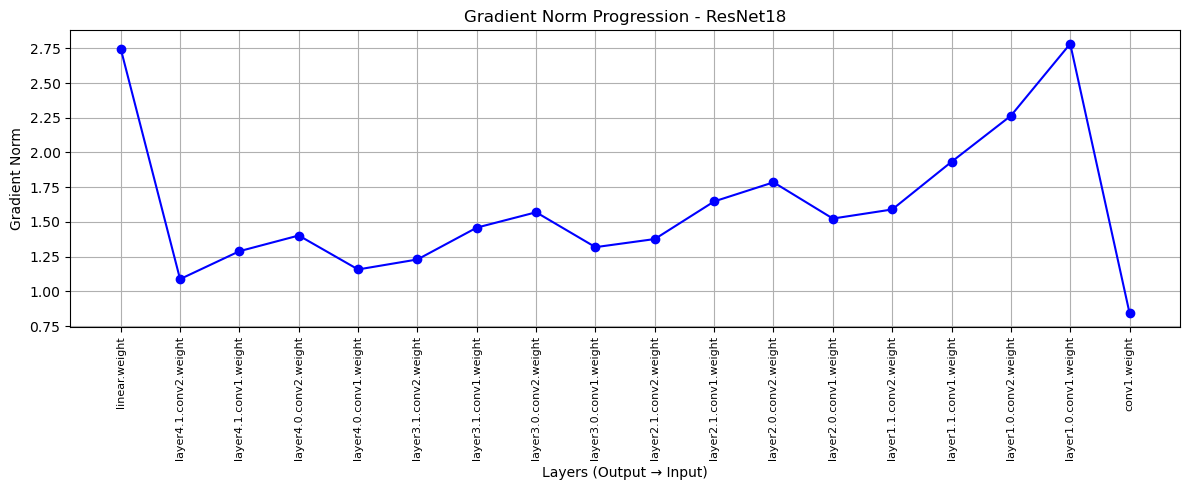

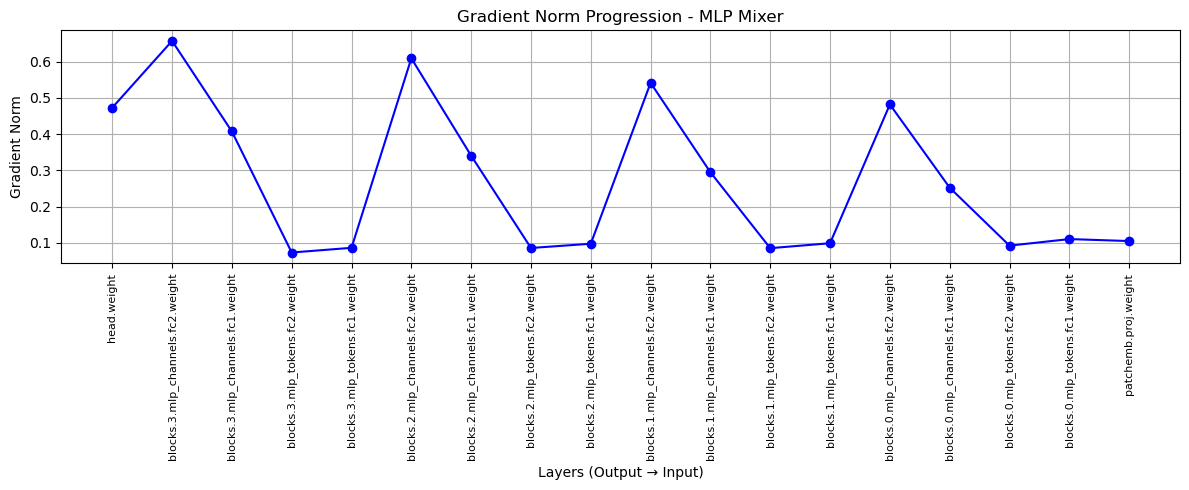

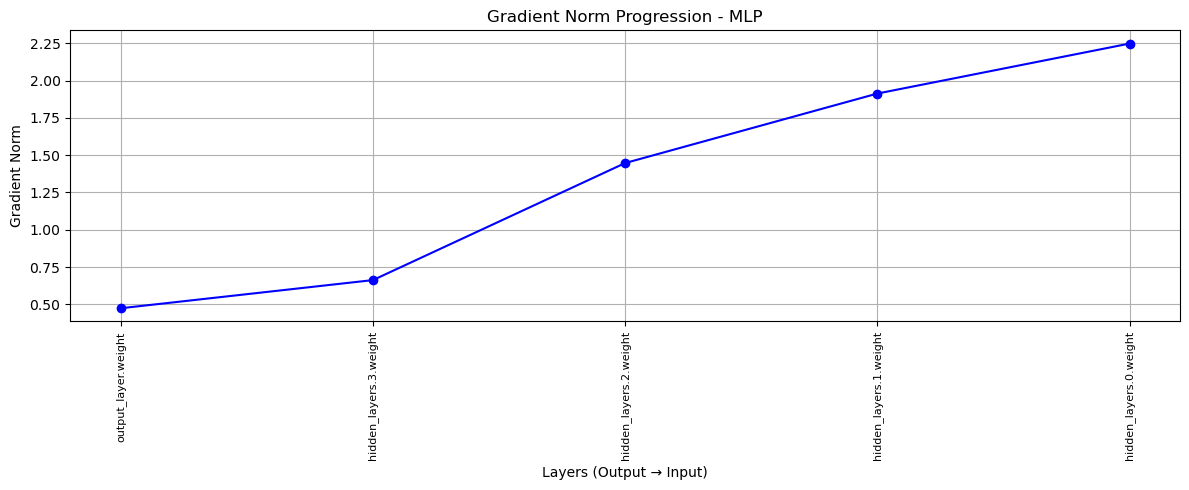

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
from resnet18 import ResNet18
from mlp import MLP
from mlpmixer import MLPMixer
from utils import cross_entropy_loss
import matplotlib.pyplot as plt

models  = [ResNet18(), MLPMixer(10, 32, 4, 256, 4, 0), MLP(3072, [1024, 512, 64, 64], 10, activation="relu")]

model_names = ["ResNet18", "MLP Mixer", "MLP"]

# Generate random input and target data (for CIFAR-10)
inputs = torch.randn(128, 3, 32, 32)  # Batch size of 16, CIFAR-10 shape
targets = torch.randint(0, 10, (128,))  # 10 classes

# Iterate through each model and create separate plots
for model, model_name in zip(models, model_names):
    # Define loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Forward pass
    outputs = model(inputs.view(inputs.shape[0], -1) if model_name == "MLP" else inputs)
    loss = loss_fn(outputs, targets)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Store gradient norms (excluding BatchNorm layers)
    grad_norms = []
    layer_names = []

    for name, param in model.named_parameters():
        # Exclude batch norm, shortcut, norm1, and norm2 layers
        if "weight" in name and not any(exclude in name.lower() for exclude in ["bn", "shortcut", "norm", "norm1", "norm2"]):
            if param.grad is not None:
                grad_norms.append(param.grad.norm().item())
                layer_names.append(name)  # Store layer names

    # Reverse order (output → input) for consistent visualization
    grad_norms.reverse()
    layer_names.reverse()

    # Create separate figure for each model
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(grad_norms)), grad_norms, marker='o', linestyle='-', color='b')
    plt.xticks(range(len(layer_names)), layer_names, rotation=90, fontsize=8)
    plt.xlabel("Layers (Output → Input)")
    plt.ylabel("Gradient Norm")
    plt.title(f"Gradient Norm Progression - {model_name}")
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
for layer_name, norms in grad_norms.items():
    avg_norm = sum(norms) / len(norms)
    print(f"Layer: {layer_name}, Average Gradient Norm: {avg_norm:.4f}")